<a href="https://colab.research.google.com/github/bhar-gav/MDS-COLAB/blob/main/MDS_using_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Step 1: Tokenization and BERT Embedding**

---



## 1. BERT Tokenizer (Pretrained - `bert-base-uncased`)

### a. Tokenize
- Load the pre-trained BERT tokenizer.
- Tokenize the sentences.

### b. Vocab
- Create an ID-to-token mapping dictionary.

### c. Encode
- Convert tokens to IDs with fixed length.
- Apply padding and truncation.

## 2. BERT Model
- Load the pre-trained BERT model.
- Get BERT embeddings for the encoded sentence sequences.
---

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
import json
import os

# Load BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()  # Set BERT to evaluation mode

# Load data from CSV
data_path = '/content/drive/My Drive/MDS/cleaned_articles.csv'
data = pd.read_csv(data_path)

# Ensure necessary columns are present
if 'row_article' not in data.columns or 'summary' not in data.columns:
    raise ValueError("Dataframe must contain 'row_article' and 'summary' columns")

# Tokenize and encode data
def encode_texts(texts, tokenizer, max_length=512):
    encoded = tokenizer(texts.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='pt')
    return encoded

def get_bert_embeddings(encoded, model):
    with torch.no_grad():
        outputs = model(**encoded)
        return outputs.last_hidden_state

# Encode articles and summaries
article_encoded = encode_texts(data['row_article'], bert_tokenizer)
summary_encoded = encode_texts(data['summary'], bert_tokenizer)

# Extract BERT embeddings for articles
article_embeddings = get_bert_embeddings(article_encoded, bert_model)

# Define max length for summaries
max_summary_length = 512

# Convert summaries to token IDs and pad/truncate
def adjust_summary_lengths(summaries, tokenizer, max_length):
    token_ids = []
    for text in summaries:
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # Add [CLS] and [SEP]
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt',
            return_attention_mask=False
        )
        token_ids.append(encoding['input_ids'].squeeze().tolist())
    return torch.tensor(token_ids)

summary_padded = adjust_summary_lengths(data['summary'], bert_tokenizer, max_summary_length)

# Create token ID to token mapping
token_id_to_token = {id: token for token, id in bert_tokenizer.get_vocab().items()}

# Define save paths
save_dir = '/content/drive/My Drive/MDS/'
file_paths = {
    'article_encoded': os.path.join(save_dir, 'article_encoded.pt'),
    'summary_encoded': os.path.join(save_dir, 'summary_encoded.pt'),
    'article_embeddings': os.path.join(save_dir, 'article_embeddings.pt'),
    'summary_padded': os.path.join(save_dir, 'summary_padded.pt'),
    'token_id_to_token': os.path.join(save_dir, 'token_id_to_token.json')
}

# Save data
try:
    torch.save(article_encoded, file_paths['article_encoded'])
    torch.save(summary_encoded, file_paths['summary_encoded'])
    torch.save(article_embeddings, file_paths['article_embeddings'])
    torch.save(summary_padded, file_paths['summary_padded'])
    with open(file_paths['token_id_to_token'], 'w') as f:
        json.dump(token_id_to_token, f)
except Exception as e:
    print(f"Error saving files: {e}")

# Debugging: Print sample data
print("Sample data:", data.head())
print("Sample encoded article:", article_encoded['input_ids'][0][:10])  # Print first 10 tokens
print("Sample encoded summary:", summary_encoded['input_ids'][0][:10])  # Print first 10 tokens
print("Sample article embedding shape:", article_embeddings.shape)
print("Sample summary padded shape:", summary_padded.shape)

# Print the length of the dictionary and the first 20 elements
print("Token ID to Token dictionary length:", len(token_id_to_token))
print("First 20 elements of the dictionary:", dict(list(token_id_to_token.items())[:20]))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Sample data:    index        id                                        row_article  \
0      0  P95-1021  d tree grammars designed to share some of the ...   
1      1  P05-1073  joint learning improves semantic role labeling...   
2      2  D09-1127  bilingually constrained monolingual shift redu...   
3      3  P02-1017  a generative constituent context model for imp...   
4      4  J90-1003  word association norms mutual information and ...   

                                             summary  row_article_length  \
0  we define a new grammar formalism called d tre...               40760   
1  title joint learning improves semantic role la...               24452   
2  conclusion we have presented a novel parsing p...               24503   
3  title a generative constituent context model f...               24502   
4  we began this paper with the psycholinguistic ...               34693   

   summary_length  
0             953  
1             583  
2             776  
3          

---
# **Test 1: Decoding Test**

## A) Load Saved Article Sequences and Summary Sequences
- Load the pre-saved article sequences and their corresponding summary sequences from your storage.

## B) Decode the Sequences
- Use the BERT tokenizer to decode the sequences and print some examples for verification.

## C) Check Consistency or Correctness
- Verify that the decoded summaries accurately reflect the content of the original articles.
- Assess consistency by comparing the length and content of decoded summaries against expected outputs.
---

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

# Load BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def decode_texts(encoded_texts, tokenizer):
    """Decode encoded texts back to original text."""
    decoded_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in encoded_texts]
    return decoded_texts

def decode_summaries_and_articles(article_encoded, summary_padded, tokenizer):
    """Decode encoded articles and padded summaries back to original text."""
    # Decode articles
    articles_decoded = decode_texts(article_encoded['input_ids'].numpy(), tokenizer)

    # Decode summaries (handling padding and truncation)
    summaries_decoded = decode_texts(summary_padded.numpy(), tokenizer)

    return articles_decoded, summaries_decoded

# Load encoded data
article_encoded = torch.load('/content/drive/My Drive/MDS/article_encoded.pt')
summary_encoded = torch.load('/content/drive/My Drive/MDS/summary_encoded.pt')
article_embeddings = torch.load('/content/drive/My Drive/MDS/article_embeddings.pt')
summary_ids = torch.load('/content/drive/My Drive/MDS/summary_ids.pt')
summary_padded = torch.load('/content/drive/My Drive/MDS/summary_padded.pt')

# Example usage
articles_decoded, summaries_decoded = decode_summaries_and_articles(
    article_encoded,
    summary_padded,
    bert_tokenizer
)

# Print a few examples for verification
print("Decoded articles (sample):", articles_decoded[:2])
print("Decoded summaries (sample):", summaries_decoded[:2])


<ipython-input-3-33fcea3494d5>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  article_encoded = torch.load('/content/drive/My Drive/MDS/article_encoded.pt')
<ipython-inpu

Decoded articles (sample): ['d tree grammars designed to share some of the advantages of tag while overcoming some its limitations two composition operations called subsertion and sister adjunction the most distinctive feaof that unlike tag there is complete uniformity in the way that the relate lexical items subsertion always corresponds to complementation and sister adjunction to modi furthermore unlike tag provide a uniform analysis for whmovement in english and kashmiri despite the fact that the wh element in kashmiri appears in sentence second position and not sentence initial position as in english we define a new grammar formalism called d tree arises from work on tree adjoining grammars tag joshi et al 1975 a salient feature of tag is the extended domain of locality it provides each elementary structure can be associated with a lexical item as in lexicalized ltag joshi 1991 properties related to the lexical item such as subcategorization agreement certain types of word order va

---
---
# **Test 2: Data Loading (Test)**

## A) Loading Encoded Article Sequences and Summary Sequences
- Load the encoded article sequences and their corresponding summary sequences from your dataset.

## B) Print Some Samples
- Print a few samples to verify the correct loading of data.

## C) Check Train, Validation, and Test Set Split
- Ensure that the data is properly split into training, validation, and test sets.

## D) Verify Shapes of Input Encoded Sequences
- Confirm the shapes of the input encoded sequences to ensure consistency.

### Sample Shapes
- **Sample article embedding shape**: `torch.Size([608, 512, 768])`
  - **608**: Number of article sequences.
  - **512**: Maximum sequence length (padded/truncated).
  - **768**: Dimensionality of BERT embeddings for each token.

- **Sample summary padded shape**: `torch.Size([608, 512])`
  - **608**: Number of summary sequences (matches articles).
  - **512**: Maximum sequence length for summaries.

- **Sample article lengths**: `[512, 512, 512, 512, 512]`
  - All articles are padded to the maximum length of 512 tokens.

- **Sample summary lengths**: `[512, 512, 512, 512, 512]`
  - All summaries are also padded to 512 tokens.

- **Batch X shape**: `torch.Size([4, 512, 768])`
  - **4**: Batch size (4 article sequences).
  - **512**: Fixed sequence length.
  - **768**: Size of embeddings for tokens.

- **Batch y shape**: `torch.Size([4, 512])`
  - **4**: Batch size (4 summary sequences).
  - **512**: Fixed sequence length for summaries.
---

In [ ]:

import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

# Load BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()  # Set BERT to evaluation mode

# Load encoded data
article_encoded = torch.load('/content/drive/My Drive/MDS/article_encoded.pt')
summary_encoded = torch.load('/content/drive/My Drive/MDS/summary_encoded.pt')
article_embeddings = torch.load('/content/drive/My Drive/MDS/article_embeddings.pt')
summary_ids = torch.load('/content/drive/My Drive/MDS/summary_ids.pt')
summary_padded = torch.load('/content/drive/My Drive/MDS/summary_padded.pt')

# Load the original data for debugging
data_path = '/content/drive/My Drive/MDS/cleaned_articles.csv'
data = pd.read_csv(data_path)

# Debugging: Print sample data
print("Sample data:", data.head())
print("Sample encoded article:", article_encoded['input_ids'][0])
print("Sample encoded summary:", summary_encoded['input_ids'][0])
print("Sample article embedding shape:", article_embeddings.shape)
print("Sample summary padded shape:", summary_padded.shape)

# Check lengths of articles and summaries
article_lengths = [len(seq) for seq in article_encoded['input_ids']]
summary_lengths = [len(seq) for seq in summary_encoded['input_ids']]

# Print some lengths to debug
print(f"Sample article lengths: {article_lengths[:5]}")
print(f"Sample summary lengths: {summary_lengths[:5]}")

# Create dataset class
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split data into train, validation, and test sets
def split_data(X, y, train_size=0.7, val_size=0.15, test_size=0.15):
    num_samples = len(X)
    indices = torch.randperm(num_samples).tolist()
    train_end = int(num_samples * train_size)
    val_end = train_end + int(num_samples * val_size)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    X_train = torch.stack([X[i] for i in train_indices])
    y_train = torch.stack([y[i] for i in train_indices])
    X_val = torch.stack([X[i] for i in val_indices])
    y_val = torch.stack([y[i] for i in val_indices])
    X_test = torch.stack([X[i] for i in test_indices])
    y_test = torch.stack([y[i] for i in test_indices])

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(article_embeddings, summary_padded)

# Create DataLoaders
batch_size = 4

train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Debugging: Check DataLoader output
for X_batch, y_batch in train_dataloader:
    print("Batch X shape:", X_batch.shape)
    print("Batch y shape:", y_batch.shape)
    break  # Remove this break to see more batches

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-3-00f871f92ecc>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unles

Sample data:    index        id                                        row_article  \
0      0  P95-1021  d tree grammars designed to share some of the ...   
1      1  P05-1073  joint learning improves semantic role labeling...   
2      2  D09-1127  bilingually constrained monolingual shift redu...   
3      3  P02-1017  a generative constituent context model for imp...   
4      4  J90-1003  word association norms mutual information and ...   

                                             summary  row_article_length  \
0  we define a new grammar formalism called d tre...               40760   
1  title joint learning improves semantic role la...               24452   
2  conclusion we have presented a novel parsing p...               24503   
3  title a generative constituent context model f...               24502   
4  we began this paper with the psycholinguistic ...               34693   

   summary_length  
0             953  
1             583  
2             776  
3          

###*check : Model saving method

In [ ]:
import torch
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

def save_model(model, vocab_size, embedding_dim, hidden_dim, output_dim, num_epochs, batch_size, model_save_path):
    try:
        torch.save({
            'model_state_dict': model.state_dict(),
            'vocab_size': output_dim,
            'embedding_dim': embedding_dim,
            'hidden_dim': hidden_dim,
            'output_dim': output_dim,
            'num_epochs': num_epochs,
            'batch_size': batch_size
        }, model_save_path)
        logging.info(f"Model saved to {model_save_path}")
    except Exception as e:
        logging.error(f"Error saving the model: {e}")
        raise


---
# **step 3 :**
 Implement a Bi-directional LSTM model with an attention mechanism to generate summaries from articles using BERT embeddings.

## Key Components

### a) Data Preprocessing
- Loads preprocessed tensors of articles and summaries.
- Utilizes BERT tokenizer to encode text data.

### b) Model Architecture
- Combines a Bi-directional LSTM with an attention mechanism.
- Uses BERT embeddings as input.
- Outputs a summary sequence.

### c) Training and Evaluation
- Splits data into training, validation, and test sets.
- Defines loss function, optimizer, and learning rate scheduler.
- Trains the model using a custom training loop.
- Evaluates performance on validation and test sets.

### d) Additional Features
- Plots training and validation metrics for visualization.
- Saves the trained model for future use.
---

Output dim: 30522
Batch X shape: torch.Size([4, 512, 768])
Batch y shape: torch.Size([4, 512])
Epoch 1/10  ----no of batches 107
Epoch 1/10, Training Loss: 3.125776960470966
Epoch 1/10, Validation Loss: 2.2785253887591153, Validation Accuracy: 72.44%
Learning Rate: [0.001]
Model saved to trained_model.pth
Epoch 2/10  ----no of batches 107
Epoch 2/10, Training Loss: 2.1323264692431296
Epoch 2/10, Validation Loss: 2.175859694895537, Validation Accuracy: 72.68%
Learning Rate: [0.001]
Model saved to trained_model.pth
Epoch 3/10  ----no of batches 107
Epoch 3/10, Training Loss: 2.089095886622634
Epoch 3/10, Validation Loss: 2.1409703648608662, Validation Accuracy: 72.90%
Learning Rate: [0.001]
Model saved to trained_model.pth
Epoch 4/10  ----no of batches 107
Epoch 4/10, Training Loss: 2.0654811547181318
Epoch 4/10, Validation Loss: 2.1777192665183027, Validation Accuracy: 73.03%
Learning Rate: [0.001]
Model saved to trained_model.pth
Epoch 5/10  ----no of batches 107
Epoch 5/10, Training L

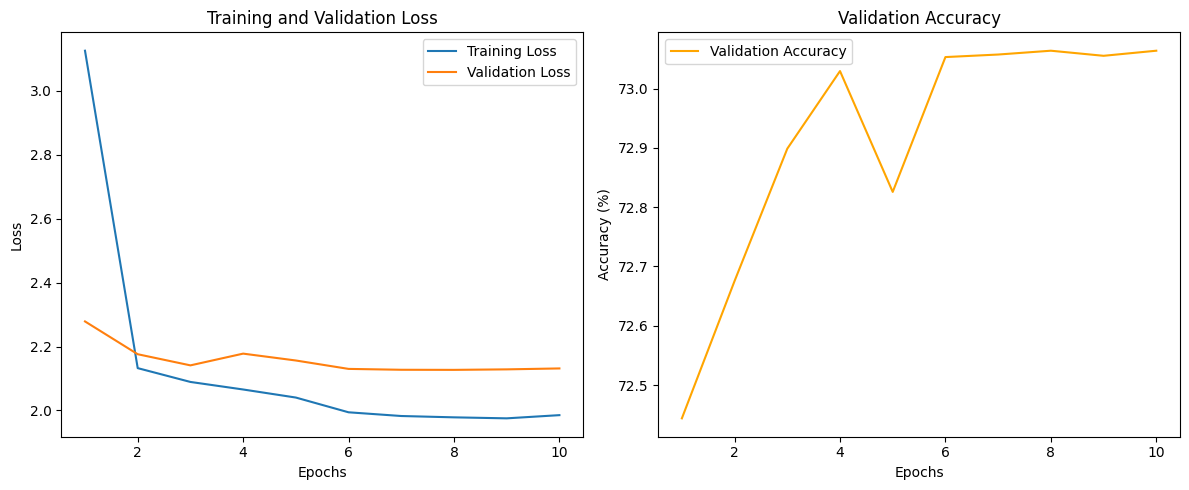

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

# Load BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()  # Set BERT to evaluation mode

# Load encoded data
article_encoded = torch.load('/content/drive/My Drive/MDS/article_encoded.pt', weights_only=False)
summary_encoded = torch.load('/content/drive/My Drive/MDS/summary_encoded.pt', weights_only=False)
article_embeddings = torch.load('/content/drive/My Drive/MDS/article_embeddings.pt', weights_only=False)
summary_ids = torch.load('/content/drive/My Drive/MDS/summary_ids.pt', weights_only=False)
summary_padded = torch.load('/content/drive/My Drive/MDS/summary_padded.pt', weights_only=False)

# Define Attention Mechanism
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_dim * 2, hidden_dim)
        self.wa = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        scores = self.wa(torch.tanh(self.Wa(lstm_output)))
        attention_weights = torch.softmax(scores, dim=1)
        context_vector = torch.bmm(attention_weights.transpose(1, 2), lstm_output)
        return context_vector.squeeze(1)

# Define BiLSTM with Attention Model
class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Output for each token position

    def forward(self, x):
        lstm_output, _ = self.lstm(x)  # Shape: [batch_size, seq_len, hidden_dim * 2]
        # Apply linear layer to every token's LSTM output
        output = self.fc(lstm_output)  # Output shape: [batch_size, seq_len, output_dim]
        return output

# Define model parameters
input_dim = bert_model.config.hidden_size  # Size of BERT embeddings (usually 768 for bert-base)
hidden_dim = 128
output_dim = len(bert_tokenizer)  # Size of the vocabulary for the output layer
print(f"Output dim: {output_dim}")

# Initialize model, loss, optimizer, and scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiLSTMWithAttention(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Example scheduler

# Create dataset
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split data into train, validation, and test sets
def split_data(X, y, train_size=0.7, val_size=0.15, test_size=0.15):
    num_samples = len(X)
    indices = torch.randperm(num_samples).tolist()
    train_end = int(num_samples * train_size)
    val_end = train_end + int(num_samples * val_size)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    X_train = torch.stack([X[i] for i in train_indices])
    y_train = torch.stack([y[i] for i in train_indices])
    X_val = torch.stack([X[i] for i in val_indices])
    y_val = torch.stack([y[i] for i in val_indices])
    X_test = torch.stack([X[i] for i in test_indices])
    y_test = torch.stack([y[i] for i in test_indices])

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(article_embeddings, summary_padded)

# Create DataLoaders
batch_size = 4
num_epochs = 10
total_batches=608/batch_size
train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Debugging: Check DataLoader output
for X_batch, y_batch in train_dataloader:
    print("Batch X shape:", X_batch.shape)
    print("Batch y shape:", y_batch.shape)
    break  # Remove this break to see more batches


import torch
import numpy as np

def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs, save_path='trained_model.pth'):
    # Lists to store losses and accuracies
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Ensure the model is in training mode
    model.train()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}  ----no of batches {len(train_dataloader)}")


        # Initialize total loss for training
        total_loss = 0
        model.train()  # Set model to training mode


        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch)
            # Reshape outputs and targets for CrossEntropyLoss
            batch_size, seq_len = X_batch.size(0), X_batch.size(1)
           # print(f"Batch Size: {batch_size}, Sequence Length: {seq_len}")

            outputs = outputs.view(-1, output_dim)  # [batch_size * seq_len, output_dim]
            #print(f"Reshaped Outputs shape: {outputs.shape}")
            y_batch = y_batch.view(-1)  # [batch_size * seq_len]
            #print(f"Reshaped y_batch shape: {y_batch.shape}")

            # Compute loss
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Update the learning rate
        scheduler.step()

        # Compute average training loss
        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}")

        # Validation
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for X_batch, y_batch in val_dataloader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # Forward pass
                outputs = model(X_batch)

                # Reshape outputs and targets for CrossEntropyLoss
                outputs = outputs.view(-1, output_dim)  # [batch_size * seq_len, output_dim]
                y_batch = y_batch.view(-1)  # [batch_size * seq_len]

                # Compute loss
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                # Compute accuracy
                _, predicted = torch.max(outputs, dim=1)
                correct_preds += (predicted == y_batch).sum().item()
                total_preds += y_batch.size(0)

        # Compute average validation loss and accuracy
        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_accuracy = correct_preds / total_preds
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy * 100:.2f}%")
        print(f"Learning Rate: {scheduler.get_last_lr()}")

        # Save the model after each epoch
        try:
            torch.save({
                'model_state_dict': model.state_dict(),
                'vocab_size': output_dim,  # Assuming output_dim is the vocabulary size
                'embedding_dim': input_dim,  # Size of BERT embeddings
                'hidden_dim': hidden_dim,  # Hidden dimension size of LSTM
                'num_epochs': num_epochs,
                'batch_size': batch_size
            }, save_path)
            print(f"Model saved to {save_path}")
        except Exception as e:
            print(f"Error saving the model: {e}")

        # Debug: Check for NaN values in losses
        if torch.isnan(torch.tensor(avg_train_loss)) or torch.isnan(torch.tensor(avg_val_loss)):
            raise ValueError("NaN values encountered in loss.")

    return train_losses, val_losses, val_accuracies

import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, [a * 100 for a in val_accuracies], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# After training
train_losses, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs)
plot_metrics(train_losses, val_losses, val_accuracies)


# Define the model save path
model_save_path = '/content/drive/My Drive/MDS/new_model.pth'



---
---
### **Summary of Training Process**

#### Model Overview
- **Output Dimension**: 30,522 (vocabulary size).
- **Batch Size**: 4
- **Input Shape**: (4, 512, 768) for input; (4, 512) for targets.

#### Training Metrics
- **Epochs**: 10
- **Batches per Epoch**: 4

#### Performance per Epoch:
- **Epoch 1**: Training Loss: 3.13, Validation Loss: 2.28, Accuracy: 72.44%
- **Epoch 2**: Training Loss: 2.13, Validation Loss: 2.18, Accuracy: 72.68%
- **Epoch 3**: Training Loss: 2.09, Validation Loss: 2.14, Accuracy: 72.90%
- **Epoch 4**: Training Loss: 2.07, Validation Loss: 2.18, Accuracy: 73.03%
- **Epoch 5**: Training Loss: 2.04, Validation Loss: 2.16, Accuracy: 72.83%
- **Epoch 6**: Training Loss: 1.99, Validation Loss: 2.13, Accuracy: 73.05%
- **Epoch 7**: Training Loss: 1.98, Validation Loss: 2.13, Accuracy: 73.06%
- **Epoch 8**: Training Loss: 1.98, Validation Loss: 2.13, Accuracy: 73.06%
- **Epoch 9**: Training Loss: 1.98, Validation Loss: 2.13, Accuracy: 73.06%
- **Epoch 10**: Training Loss: 1.99, Validation Loss: 2.13, Accuracy: 73.06%

#### Learning Rate Adjustments
- Initial: 0.001 (first 5 epochs), Reduced to 0.0001 (next 4 epochs), Final epoch: 1e-05

#### Model Saving
- Model saved after each epoch.

### Overall Insights
- Training loss decreased steadily, while validation accuracy stabilized around 73.06%.
---


In [ ]:
import torch

# Define Attention Mechanism
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_dim * 2, hidden_dim)
        self.wa = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        scores = self.wa(torch.tanh(self.Wa(lstm_output)))
        attention_weights = torch.softmax(scores, dim=1)
        context_vector = torch.bmm(attention_weights.transpose(1, 2), lstm_output)
        return context_vector.squeeze(1)

# Define BiLSTM with Attention Model
class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Output for each token position

    def forward(self, x):
        lstm_output, _ = self.lstm(x)  # Shape: [batch_size, seq_len, hidden_dim * 2]
        # Apply linear layer to every token's LSTM output
        output = self.fc(lstm_output)  # Output shape: [batch_size, seq_len, output_dim]
        return output


# Load the saved model
def load_model(model_path):
    checkpoint = torch.load(model_path)
    model = BiLSTMWithAttention(
        input_dim=checkpoint['embedding_dim'],
        hidden_dim=checkpoint['hidden_dim'],
        output_dim=checkpoint['output_dim']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

# Define the model path
model_path = '/content/drive/My Drive/MDS/trained_model.pth'
model = load_model(model_path)

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()


<ipython-input-14-a47dfab1d22f>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


BiLSTMWithAttention(
  (lstm): LSTM(768, 128, batch_first=True, bidirectional=True)
  (attention): Attention(
    (Wa): Linear(in_features=256, out_features=128, bias=True)
    (wa): Linear(in_features=128, out_features=1, bias=False)
  )
  (fc): Linear(in_features=256, out_features=30522, bias=True)
)

In [ ]:
pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=98494c234b7caf356ae6d328c07feff55232ab68eada81f9af2b1fca989ce3c1
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


---
### **Step 4:**
Implemented a Bi-directional LSTM model with an attention mechanism for summarizing articles using BERT embeddings.
### Key Components:

1. **Model Definition**:
   - **Attention Class**: Implements an attention mechanism using linear layers and softmax to compute attention weights.
   - **BiLSTMWithAttention Class**: Combines a bidirectional LSTM with the attention mechanism and a fully connected layer for output generation.

2. **Model Loading**:
   - `load_model`: Loads a trained model from a specified path, restoring its state.

3. **Summary Generation**:
   - `generate_summaries`: Uses the model to generate summaries from input batches, converting logits to predicted token IDs.

4. **Token Decoding**:
   - `decode_tokens`: Converts token IDs back into human-readable text using a BERT tokenizer, with debug prints for clarity.

5. **ROUGE Score Calculation**:
   - `calculate_rouge_scores`: Computes ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L) for generated summaries compared to reference summaries.

6. **Testing the Model**:
   - `test_model`: Loads the model, generates summaries, decodes them, extracts reference summaries, and computes ROUGE scores.

7. **Dataset Class**:
   - **TextDataset Class**: Custom dataset class for handling input-output pairs.

8. **Data Splitting**:
   - `split_data`: Randomly splits data into training, validation, and test sets.

9. **Data Loading**:
   - Loads preprocessed article embeddings and summary tensors, creating DataLoader instances for batch processing.

10. **Execution**:
   - Initializes the BERT tokenizer, sets up the device (CPU or GPU), and invokes the testing function to evaluate the model.

#### Overall Workflow:
1. Define the model architecture.
2. Load preprocessed data.
3. Split data into training, validation, and test sets.
4. Create DataLoaders for batch processing.
5. Test the model and evaluate using ROUGE scores.
---



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from rouge_score import rouge_scorer
import numpy as np

# Define the model classes (BiLSTM with Attention)
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_dim * 2, hidden_dim)
        self.wa = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        scores = self.wa(torch.tanh(self.Wa(lstm_output)))
        attention_weights = torch.softmax(scores, dim=1)
        context_vector = torch.bmm(attention_weights.transpose(1, 2), lstm_output)
        return context_vector.squeeze(1)

class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Output for each token position

    def forward(self, x):
        lstm_output, _ = self.lstm(x)  # Shape: [batch_size, seq_len, hidden_dim * 2]
        context_vector = self.attention(lstm_output)
        output = self.fc(context_vector)  # Output shape: [batch_size, output_dim]
        return output

# Define a function to load the model
def load_model(model_path):
    checkpoint = torch.load(model_path)
    model = BiLSTMWithAttention(
        input_dim=checkpoint['embedding_dim'],
        hidden_dim=checkpoint['hidden_dim'],
        output_dim=checkpoint['vocab_size']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set model to evaluation mode
    return model

# Define a function to generate summaries
def generate_summaries(model, dataloader, device):
    model.eval()
    generated_summaries = []

    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)

            # Convert logits to token IDs
            summaries = torch.argmax(outputs, dim=-1)  # Get the predicted tokens
            generated_summaries.extend(summaries.cpu().numpy())

    return generated_summaries

# Define a function to decode token IDs into text
def decode_tokens(token_ids, tokenizer):
    """
    Decode a list of token IDs into human-readable text using a tokenizer.
    Includes debugging steps to ensure proper token decoding.

    Args:
        token_ids (list or numpy.ndarray): List of token IDs to decode.
        tokenizer (BertTokenizer): The tokenizer used for encoding and decoding.

    Returns:
        List of decoded summaries as strings.
    """
    decoded_summaries = []

    if isinstance(token_ids[0], (list, np.ndarray)):
        for idx, ids in enumerate(token_ids):
            print(f"\nDecoding batch index {idx}")
            print(f"Original Token IDs: {ids[:20]}...")  # Print the first 20 IDs for inspection

            # Remove padding tokens
            ids = list(filter(lambda x: x != tokenizer.pad_token_id, ids))
            print(f"Token IDs after removing padding: {ids[:20]}...")

            # Convert IDs to tokens
            tokens = tokenizer.convert_ids_to_tokens(ids, skip_special_tokens=True)
            print(f"Tokens: {tokens[:20]}...")

            # Convert tokens to string
            decoded_text = tokenizer.convert_tokens_to_string(tokens)
            print(f"Decoded Text: {decoded_text[:100]}...")  # Print the first 100 characters

            decoded_summaries.append(decoded_text)
    else:
        print(f"\nDecoding single set of token IDs")
        print(f"Original Token IDs: {token_ids[:20]}...")

        # Remove padding tokens
        token_ids = list(filter(lambda x: x != tokenizer.pad_token_id, token_ids))
        print(f"Token IDs after removing padding: {token_ids[:20]}...")

        # Convert IDs to tokens
        tokens = tokenizer.convert_ids_to_tokens(token_ids, skip_special_tokens=True)
        print(f"Tokens: {tokens[:20]}...")

        # Convert tokens to string
        decoded_text = tokenizer.convert_tokens_to_string(tokens)
        print(f"Decoded Text: {decoded_text[:100]}...")

        decoded_summaries.append(decoded_text)

    return decoded_summaries

# Define a function to calculate ROUGE scores
def calculate_rouge_scores(generated_summaries, reference_summaries):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for idx, (generated, reference) in enumerate(zip(generated_summaries, reference_summaries)):
        print(f"\nCalculating ROUGE scores for sample index {idx}")
        print(f"Generated Summary: {generated}")
        print(f"Reference Summary: {reference}")

        score = scorer.score(reference, generated)
        for key in scores.keys():
            scores[key].append(score[key].fmeasure)
            print(f"{key} F-measure: {score[key].fmeasure:.4f}")

    avg_scores = {key: sum(value) / len(value) for key, value in scores.items()}
    return avg_scores

# Define a function to test the model and evaluate with ROUGE
def test_model(model_path, test_dataloader, device, tokenizer):
    # Load the model
    model = load_model(model_path).to(device)

    # Generate summaries
    generated_summaries = generate_summaries(model, test_dataloader, device)

    # Decode generated summaries
    decoded_generated_summaries = decode_tokens(generated_summaries, tokenizer)

    # Extract reference summaries from the dataloader
    reference_summaries = []
    for _, y_batch in test_dataloader:
        reference_summaries.extend(y_batch.cpu().numpy())

    # Decode reference summaries
    decoded_reference_summaries = decode_tokens(reference_summaries, tokenizer)

    # Calculate ROUGE scores
    rouge_scores = calculate_rouge_scores(decoded_generated_summaries, decoded_reference_summaries)

    print("ROUGE Scores:")
    for key, score in rouge_scores.items():
        print(f"{key}: {score:.4f}")

# Create dataset class
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split data into train, validation, and test sets
def split_data(X, y, train_size=0.7, val_size=0.15, test_size=0.15):
    num_samples = len(X)
    indices = torch.randperm(num_samples).tolist()
    train_end = int(num_samples * train_size)
    val_end = train_end + int(num_samples * val_size)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    X_train = torch.stack([X[i] for i in train_indices])
    y_train = torch.stack([y[i] for i in train_indices])
    X_val = torch.stack([X[i] for i in val_indices])
    y_val = torch.stack([y[i] for i in val_indices])
    X_test = torch.stack([X[i] for i in test_indices])
    y_test = torch.stack([y[i] for i in test_indices])

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Load encoded data
article_embeddings = torch.load('/content/drive/My Drive/MDS/article_embeddings.pt')
summary_padded = torch.load('/content/drive/My Drive/MDS/summary_padded.pt')

(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(article_embeddings, summary_padded)

# Create DataLoaders
batch_size = 4

test_dataset = TextDataset(X_test, y_test)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path to model
model_save_path = '/content/drive/My Drive/MDS/base_model.pth'

# Test the model and calculate ROUGE scores
test_model(model_save_path, test_dataloader, device, bert_tokenizer)


<ipython-input-16-051fe6046aec>:193: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  article_embeddings = torch.load('/content/drive/My Drive/MDS/article_embeddings.pt')
<ipyt


Decoding single set of token IDs
Original Token IDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...
Token IDs after removing padding: []...
Tokens: []...
Decoded Text: ...

Decoding batch index 0
Original Token IDs: [ 2516 11566  4353  2389  1998 24012  2592  2005  2112  1997  4613 15946
  7875 20528  6593  1999  2023  3259  2057  6848]...
Token IDs after removing padding: [2516, 11566, 4353, 2389, 1998, 24012, 2592, 2005, 2112, 1997, 4613, 15946, 7875, 20528, 6593, 1999, 2023, 3259, 2057, 6848]...
Tokens: ['title', 'combining', 'distribution', '##al', 'and', 'morphological', 'information', 'for', 'part', 'of', 'speech', 'induction', '##ab', '##stra', '##ct', 'in', 'this', 'paper', 'we', 'discuss']...
Decoded Text: title combining distributional and morphological information for part of speech inductionabstract in...

Decoding batch index 1
Original Token IDs: [ 2144 17463 19234  2015  4070  2005  1037  6937 10817  1997  2035 24402
 10697  2011  9686  2140  2394  2004

---
---
### Summary of Decoding and ROUGE Score Calculation

1. **Original Token IDs**:
   - Example: `[2516, 5860, 20026, 3981, ...]`

2. **Token IDs After Removing Padding**:
   - Result: `[2516, 5860, 20026, 3981, 6024, ...]`

3. **Tokens**:
   - Example Tokens: `['the', 'first', 'two', 'systems', 'called', ...]`

4. **Decoded Text**:
   - Result: `"the first two systems called nlg1 and ..."`

### ROUGE Scores

- **ROUGE-1 F-measure**: 0.0000  
- **ROUGE-2 F-measure**: 0.0000  
- **ROUGE-L F-measure**: 0.0000  

### Observations

- **ROUGE Scores**: All scores are 0. This indicates that the generated summaries did not match the reference summaries.
  
- **Encoded Sequences**: The sequences are correct, and the decoding of outputs is accurate.

- **Reference Summaries**: The reference summaries are correct.

- **Issue with Generated Summaries**: The outputs consist solely of `<pad>` tokens (index = 0), indicating a failure to generate meaningful content.

### Conclusion

- **Overfitting**: The model may be overfitting due to the prevalence of padding tokens in the encoded sequences.

- **Need for Padding**: Padding is essential to maintain consistent input shapes, making the model easier to handle and less error-prone during training.
---

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from rouge_score import rouge_scorer
import numpy as np

# Define Attention Mechanism
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_dim * 2, hidden_dim)
        self.wa = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        scores = self.wa(torch.tanh(self.Wa(lstm_output)))
        attention_weights = torch.softmax(scores, dim=1)
        context_vector = torch.bmm(attention_weights.transpose(1, 2), lstm_output)
        return context_vector.squeeze(1)

# Define BiLSTM with Attention Model
class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Output for each token position

    def forward(self, x):
        lstm_output, _ = self.lstm(x)  # Shape: [batch_size, seq_len, hidden_dim * 2]
        output = self.fc(lstm_output)  # Output shape: [batch_size, seq_len, output_dim]
        return output

# Define a function to load the model
def load_model(model_path):
    checkpoint = torch.load(model_path, weights_only=False)
    model = BiLSTMWithAttention(
        input_dim=checkpoint['embedding_dim'],
        hidden_dim=checkpoint['hidden_dim'],
        output_dim=checkpoint['vocab_size']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set model to evaluation mode
    return model

# Create dataset class
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split data into train, validation, and test sets
def split_data(X, y, train_size=0.7, val_size=0.15, test_size=0.15):
    num_samples = len(X)
    indices = torch.randperm(num_samples).tolist()
    train_end = int(num_samples * train_size)
    val_end = train_end + int(num_samples * val_size)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    X_train = torch.stack([X[i] for i in train_indices])
    y_train = torch.stack([y[i] for i in train_indices])
    X_val = torch.stack([X[i] for i in val_indices])
    y_val = torch.stack([y[i] for i in val_indices])
    X_test = torch.stack([X[i] for i in test_indices])
    y_test = torch.stack([y[i] for i in test_indices])

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Load encoded data
article_embeddings = torch.load('/content/drive/My Drive/MDS/article_embeddings.pt', weights_only=False)
summary_padded = torch.load('/content/drive/My Drive/MDS/summary_padded.pt', weights_only=False)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(article_embeddings, summary_padded)

# Create DataLoaders
batch_size = 4
test_dataset = TextDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define loss function
output_dim = len(bert_tokenizer)  # Ensure this matches your vocab size
criterion = nn.CrossEntropyLoss()

# Define a function to decode token IDs into text
def decode_tokens(token_ids, tokenizer):
    decoded_summaries = []
    for ids in token_ids:
        ids = list(filter(lambda x: x != tokenizer.pad_token_id, ids))
        tokens = tokenizer.convert_ids_to_tokens(ids, skip_special_tokens=True)
        decoded_text = tokenizer.convert_tokens_to_string(tokens)
        decoded_summaries.append(decoded_text)
    return decoded_summaries

# Define a function to test the model and evaluate with ROUGE
def test_model(model_path, test_dataloader, device, tokenizer):
    # Load the model
    model = load_model(model_path).to(device)

    model.eval()  # Set model to evaluation mode
    test_loss = 0
    correct_preds = 0
    total_preds = 0
    all_summaries = []

    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)

            # Print shapes for debugging
            batch_size, seq_len = X_batch.size(0), X_batch.size(1)
            print(f"Batch Size: {batch_size}, Sequence Length: {seq_len}")
            print(f"Outputs shape: {outputs.shape}")  # Should be [batch_size, seq_len, output_dim]
            print(f"Targets shape: {y_batch.shape}")   # Should be [batch_size, seq_len]

            # Reshape outputs and targets for CrossEntropyLoss
            outputs = outputs.view(-1, output_dim)  # [batch_size * seq_len, output_dim]
            y_batch = y_batch.view(-1)  # [batch_size * seq_len]

            # Compute loss
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

            # Calculate number of correct predictions
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == y_batch).sum().item()
            total_preds += y_batch.size(0)

            # Generate summaries
            pred_indices = predicted.view(batch_size, seq_len).cpu().numpy()
            summaries = decode_tokens(pred_indices, tokenizer)
            all_summaries.extend(summaries)

    # Average test loss and accuracy
    avg_test_loss = test_loss / len(test_dataloader)
    test_accuracy = correct_preds / total_preds

    print(f"Test Loss: {avg_test_loss}")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    return {
        'average_test_loss': avg_test_loss,
        'test_accuracy': test_accuracy,
        'generated_summaries': all_summaries
    }

# Path to model
model_save_path = '/content/drive/My Drive/MDS/trained_model.pth'

test_results = test_model(model_save_path, test_dataloader, device, bert_tokenizer)

# Print some example summaries
for i, summary in enumerate(test_results['generated_summaries'][:20]):  # Print first 20 summaries
    print(f"Summary {i+1}: {summary}")

# Optionally calculate ROUGE scores if you have reference summaries
# def calculate_rouge_scores(generated_summaries, reference_summaries):
#     scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
#     scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
#     for generated, reference in zip(generated_summaries, reference_summaries):
#         score = scorer.score(reference, generated)
#         for key in scores.keys():
#             scores[key].append(score[key].fmeasure)
#     avg_scores = {key: sum(value) / len(value) for key, value in scores.items()}
#     return avg_scores

# Optionally add reference summaries and compute ROUGE
# reference_summaries = [...]  # Add your reference summaries
# rouge_scores = calculate_rouge_scores(test_results['generated_summaries'], reference_summaries)
# print("\nROUGE Scores:")
# for metric, score in rouge_scores.items():
#     print(f"{metric}: {score:.4f}")


Batch Size: 4, Sequence Length: 512
Outputs shape: torch.Size([4, 512, 30522])
Targets shape: torch.Size([4, 512])
Batch Size: 4, Sequence Length: 512
Outputs shape: torch.Size([4, 512, 30522])
Targets shape: torch.Size([4, 512])
Batch Size: 4, Sequence Length: 512
Outputs shape: torch.Size([4, 512, 30522])
Targets shape: torch.Size([4, 512])
Batch Size: 4, Sequence Length: 512
Outputs shape: torch.Size([4, 512, 30522])
Targets shape: torch.Size([4, 512])
Batch Size: 4, Sequence Length: 512
Outputs shape: torch.Size([4, 512, 30522])
Targets shape: torch.Size([4, 512])
Batch Size: 4, Sequence Length: 512
Outputs shape: torch.Size([4, 512, 30522])
Targets shape: torch.Size([4, 512])
Batch Size: 4, Sequence Length: 512
Outputs shape: torch.Size([4, 512, 30522])
Targets shape: torch.Size([4, 512])
Batch Size: 4, Sequence Length: 512
Outputs shape: torch.Size([4, 512, 30522])
Targets shape: torch.Size([4, 512])
Batch Size: 4, Sequence Length: 512
Outputs shape: torch.Size([4, 512, 30522])
T

Batch X shape: torch.Size([4, 512, 768])
Batch y shape: torch.Size([4, 512])
Epoch 1/10
Training Loss: 3.0685762701747574
Validation Loss: 2.2729146584220556, Validation Accuracy: 71.65%
Learning Rate: [0.001]
Model saved to trained_model.pth
Epoch 2/10
Training Loss: 2.125394532613665
Validation Loss: 2.168547044629636, Validation Accuracy: 71.65%
Learning Rate: [0.001]
Model saved to trained_model.pth
Epoch 3/10
Training Loss: 2.0744687084839724
Validation Loss: 2.163432478904724, Validation Accuracy: 72.27%
Learning Rate: [0.001]
Model saved to trained_model.pth
Epoch 4/10
Training Loss: 2.0600598705149142
Validation Loss: 2.156955309536146, Validation Accuracy: 72.23%
Learning Rate: [0.001]
Model saved to trained_model.pth
Epoch 5/10
Training Loss: 2.0400434888411905
Validation Loss: 2.1570185733878096, Validation Accuracy: 72.28%
Learning Rate: [0.0001]
Model saved to trained_model.pth
Epoch 6/10
Training Loss: 2.0079661318074877
Validation Loss: 2.145570376644964, Validation Accu

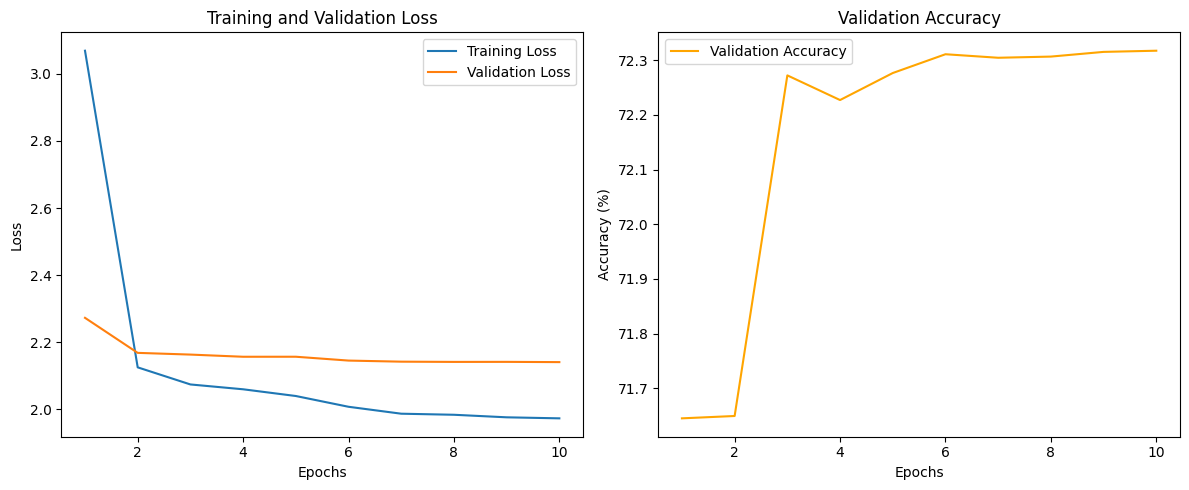

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt

# Load BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()  # Set BERT to evaluation mode

# Load precomputed data from files
article_embeddings = torch.load('/content/drive/My Drive/MDS/article_embeddings.pt', weights_only=False)
summary_padded = torch.load('/content/drive/My Drive/MDS/summary_padded.pt', weights_only=False)

# Define the Attention Mechanism class
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        # Linear layers to compute attention scores
        self.Wa = nn.Linear(hidden_dim * 2, hidden_dim)
        self.wa = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        # Compute attention scores
        scores = self.wa(torch.tanh(self.Wa(lstm_output)))
        attention_weights = torch.softmax(scores, dim=1)
        # Compute context vector
        context_vector = torch.bmm(attention_weights.transpose(1, 2), lstm_output)
        return context_vector.squeeze(1)

# Define the BiLSTM with Attention Model class
class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMWithAttention, self).__init__()
        # Bi-directional LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        # Attention mechanism
        self.attention = Attention(hidden_dim)
        # Fully connected layer to produce output
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        # Get LSTM outputs
        lstm_output, _ = self.lstm(x)
        # Apply fully connected layer
        output = self.fc(lstm_output)
        return output

# Define model parameters
input_dim = bert_model.config.hidden_size  # Size of BERT embeddings (usually 768 for bert-base)
hidden_dim = 128  # Size of hidden layer in LSTM
output_dim = len(bert_tokenizer)  # Size of the vocabulary for the output layer

# Initialize the model, loss function, optimizer, and learning rate scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiLSTMWithAttention(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Learning rate scheduler

# Define dataset class
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Function to split data into train, validation, and test sets
def split_data(X, y, train_size=0.7, val_size=0.15, test_size=0.15):
    num_samples = len(X)
    indices = torch.randperm(num_samples).tolist()  # Randomly shuffle indices
    train_end = int(num_samples * train_size)
    val_end = train_end + int(num_samples * val_size)

    # Split indices for train, validation, and test sets
    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    X_train = torch.stack([X[i] for i in train_indices])
    y_train = torch.stack([y[i] for i in train_indices])
    X_val = torch.stack([X[i] for i in val_indices])
    y_val = torch.stack([y[i] for i in val_indices])
    X_test = torch.stack([X[i] for i in test_indices])
    y_test = torch.stack([y[i] for i in test_indices])

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Split data
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(article_embeddings, summary_padded)

# Create DataLoaders for training, validation, and test sets
batch_size = 4
num_epochs = 10
train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Debugging: Check DataLoader output
for X_batch, y_batch in train_dataloader:
    print("Batch X shape:", X_batch.shape)
    print("Batch y shape:", y_batch.shape)
    break  # Remove this break to see more batches

# Training function
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs, save_path='trained_model.pth'):
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        total_loss = 0
        model.train()  # Set model to training mode

        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            outputs = model(X_batch)
            outputs = outputs.view(-1, output_dim)  # Flatten outputs for loss calculation
            y_batch = y_batch.view(-1)  # Flatten targets for loss calculation

            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print(f"Training Loss: {avg_train_loss}")

        # Validation
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for X_batch, y_batch in val_dataloader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                outputs = model(X_batch)
                outputs = outputs.view(-1, output_dim)  # Flatten outputs for loss calculation
                y_batch = y_batch.view(-1)  # Flatten targets for loss calculation

                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, dim=1)
                correct_preds += (predicted == y_batch).sum().item()
                total_preds += y_batch.size(0)

        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_accuracy = correct_preds / total_preds
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)
        print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy * 100:.2f}%")
        print(f"Learning Rate: {scheduler.get_last_lr()}")

        # Save the model after each epoch
        try:
            torch.save({
                'model_state_dict': model.state_dict(),
                'vocab_size': output_dim,
                'embedding_dim': input_dim,
                'hidden_dim': hidden_dim,
                'num_epochs': num_epochs,
                'batch_size': batch_size
            }, save_path)
            print(f"Model saved to {save_path}")
        except Exception as e:
            print(f"Error saving the model: {e}")

        # Check for NaN values in loss
        if torch.isnan(torch.tensor(avg_train_loss)) or torch.isnan(torch.tensor(avg_val_loss)):
            raise ValueError("NaN values encountered in loss.")

    return train_losses, val_losses, val_accuracies

# Function to plot training and validation metrics
def plot_metrics(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, [a * 100 for a in val_accuracies], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Run training and plot metrics
train_losses, val_losses, val_accuracies = train_model(
    model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs
)
plot_metrics(train_losses, val_losses, val_accuracies)

# Define the model save path
model_save_path = '/content/drive/My Drive/MDS/trained_model.pth'


<ipython-input-43-640f6cea027e>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Raw Outputs (sample): [[ 5.3910894 -4.193077  -4.629571  ... -4.163252  -4.70815   -3.8079221]
 [ 4.5712414 -4.3540816 -4.9889703 ... -4.905571  -5.004534  -4.224471 ]
 [ 5.374689  -5.1315665 -5.7992573 ... -5.7147326 -5.7440786 -4.9051476]
 ...
 [11.432506  -6.376678  -7.3138914 ... -6.95828   -7.3813586 -6.032955 ]
 [10.965229  -6.060764  -7.033045  ... -6.722931  -7.109028  -5.763381 ]
 [ 8.875593  -4.672011  -5.519513  ... -5.33352   -5.681059  -4.611781 ]]
Predicted IDs (sample): [2516    0    0 ...    0    0    0]
True IDs (sample): [ 101 1996 6994 ...    0    0    0]
Raw Outputs (sample): [[ 5.6837597 -4.3853607 -4.8668165 ... -4.3505855 -4.9523373 -3.980053 ]
 [ 4.889459  -4.557053  -5.299223  ... -4.9385777 -5.0391626 -4.432111 ]
 [ 5.023398  -4.8595014 -5.6130133 ... -5.3755984 -5.3683424 -4.6181936]
 ...
 [11.222199  -6.247871  -7.2037525 ... -6.89408   -7.2696695 -5.8674507]
 [11.021474  -6.182937  -7.119585  ... -6.7914667 -7.161149  -5.829925 ]
 [ 9.249379  -4.9574633 -5.

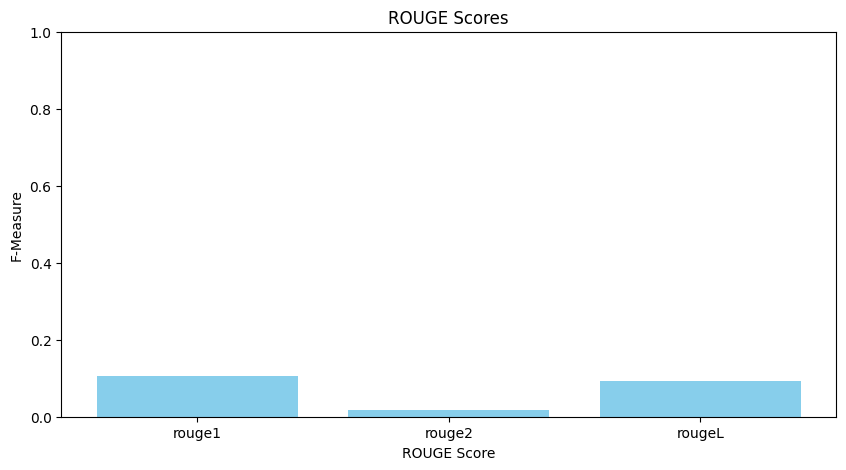

In [ ]:
!pip install rouge-score

import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
# Define the Attention Mechanism class
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        # Linear layers to compute attention scores
        self.Wa = nn.Linear(hidden_dim * 2, hidden_dim)
        self.wa = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        # Compute attention scores
        scores = self.wa(torch.tanh(self.Wa(lstm_output)))
        attention_weights = torch.softmax(scores, dim=1)
        # Compute context vector
        context_vector = torch.bmm(attention_weights.transpose(1, 2), lstm_output)
        return context_vector.squeeze(1)

# Define the BiLSTM with Attention Model class
class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMWithAttention, self).__init__()
        # Bi-directional LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        # Attention mechanism
        self.attention = Attention(hidden_dim)
        # Fully connected layer to produce output
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        # Get LSTM outputs
        lstm_output, _ = self.lstm(x)
        # Apply fully connected layer
        output = self.fc(lstm_output)
        return output

def test_model(model_path, test_dataloader, criterion, token_id_to_token, device):
    # Load the saved model
    checkpoint = torch.load(model_path)
    model = BiLSTMWithAttention(
        input_dim=checkpoint['embedding_dim'],
        hidden_dim=checkpoint['hidden_dim'],
        output_dim=checkpoint['vocab_size']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()  # Set model to evaluation mode

    # Lists to store predictions and references
    all_preds = []
    all_refs = []
    test_loss = 0
    correct_preds = 0
    total_preds = 0

    # Evaluate the model
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)

            # Print raw outputs for debugging
            print("Raw Outputs (sample):", outputs[0].cpu().numpy())

            # Reshape outputs and targets for CrossEntropyLoss
            batch_size, seq_len = X_batch.size(0), X_batch.size(1)
            outputs = outputs.view(-1, checkpoint['vocab_size'])  # [batch_size * seq_len, output_dim]
            y_batch = y_batch.view(-1)  # [batch_size * seq_len]

            # Compute loss
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, dim=1)
            correct_preds += (predicted == y_batch).sum().item()
            total_preds += y_batch.size(0)

            # Debug: Print raw predictions and references
            print("Predicted IDs (sample):", predicted.cpu().numpy())
            print("True IDs (sample):", y_batch.cpu().numpy())

            # Decode predictions and references
            preds = predicted.cpu().numpy()
            refs = y_batch.cpu().numpy()
            all_preds.extend(preds)
            all_refs.extend(refs)

    # Compute average test loss and accuracy
    avg_test_loss = test_loss / len(test_dataloader)
    avg_test_accuracy = correct_preds / total_preds

    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {avg_test_accuracy * 100:.2f}%")

    # Decode predictions and references
    decoded_preds = [token_id_to_token.get(str(pred), '[UNK]') for pred in all_preds]
    decoded_refs = [token_id_to_token.get(str(ref), '[UNK]') for ref in all_refs]



    return decoded_preds, decoded_refs

# Example usage
model_save_path = '/content/drive/My Drive/MDS/trained_model.pth'

# Load the token_id_to_token JSON file
json_file_path = '/content/drive/My Drive/MDS/token_id_to_token.json'

with open(json_file_path, 'r') as file:
    token_id_to_token = json.load(file)

# Define the criterion
criterion = nn.CrossEntropyLoss()

# Run the test
decoded_preds, decoded_refs = test_model(
    model_save_path,
    test_dataloader,
    criterion,
    token_id_to_token,
    device
)

#strip pad token
decoded_preds = [token for token in decoded_preds if token != '[PAD]']

# Print some examples
print("Decoded Predictions (sample):", decoded_preds[:20])
print("Decoded References (sample):", decoded_refs[:20])
# Decode predictions and references

p=2516
r=2516
# Ensure the lookup ID is an integer if dictionary keys are integers
id_to_check = 2516
if isinstance(id_to_check, int):
    token = token_id_to_token.get(str(id_to_check), '[UNK]')

print(f"Token for ID {id_to_check}: {token}")

p_check = [token_id_to_token.get(p,'unk')]
r_check = [token_id_to_token.get(r, '[UNK]') ]
print("Decoded Predictions (sample):", p_check)
print("Decoded References (sample):", r_check)
print("check :: ")



# Define the ROUGE score calculation function
def calculate_rouge_scores(predictions, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    rouge_scores = {
        'rouge1': 0,
        'rouge2': 0,
        'rougeL': 0,
    }

    num_samples = len(predictions)

    for pred, ref in zip(predictions, references):
        scores = scorer.score(' '.join(ref), ' '.join(pred))
        for key in rouge_scores.keys():
            rouge_scores[key] += scores[key].fmeasure

    # Average scores
    for key in rouge_scores.keys():
        rouge_scores[key] /= num_samples

    return rouge_scores

# Plot ROUGE scores
def plot_rouge_scores(rouge_scores):
    plt.figure(figsize=(10, 5))
    plt.bar(rouge_scores.keys(), rouge_scores.values(), color='skyblue')
    plt.xlabel('ROUGE Score')
    plt.ylabel('F-Measure')
    plt.title('ROUGE Scores')
    plt.ylim(0, 1)
    plt.show()

# Calculate ROUGE scores
rouge_scores = calculate_rouge_scores(decoded_preds, decoded_refs)

# Print ROUGE scores
print("ROUGE Scores:")
for key, value in rouge_scores.items():
    print(f"{key}: {value:.4f}")

# Plot ROUGE scores
plot_rouge_scores(rouge_scores)

<ipython-input-49-904b94568d81>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Test Loss: 7.3232
Test Accuracy: 71.96%
Decoded Predictions (sample): ['title', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Decoded References (sample): ['[CLS]', 'the', 'tool', '##kit', 'also', 'implements', 'suffix', 'array', 'grammar', 'extraction', 'and', 'minimum', 'error', 'rate', 'training', 'it', 'is', 'written', 'in', 'java']
ROUGE Scores:
rouge1: 0.7629
rouge2: 0.7220
rougeL: 0.7618


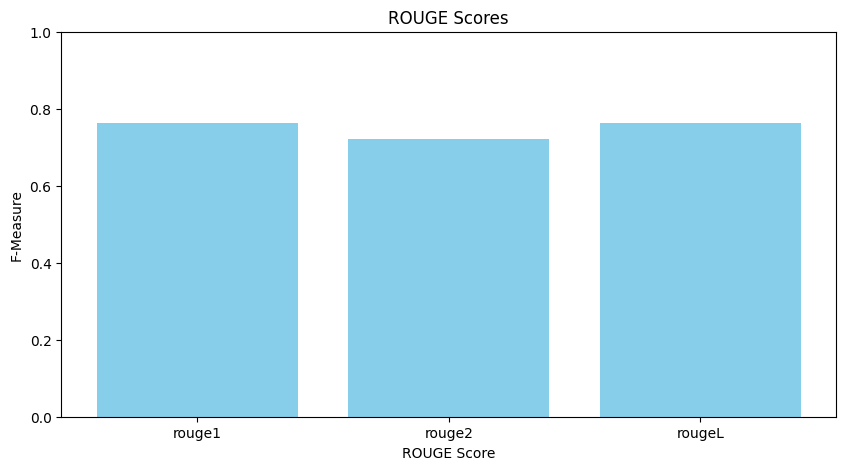

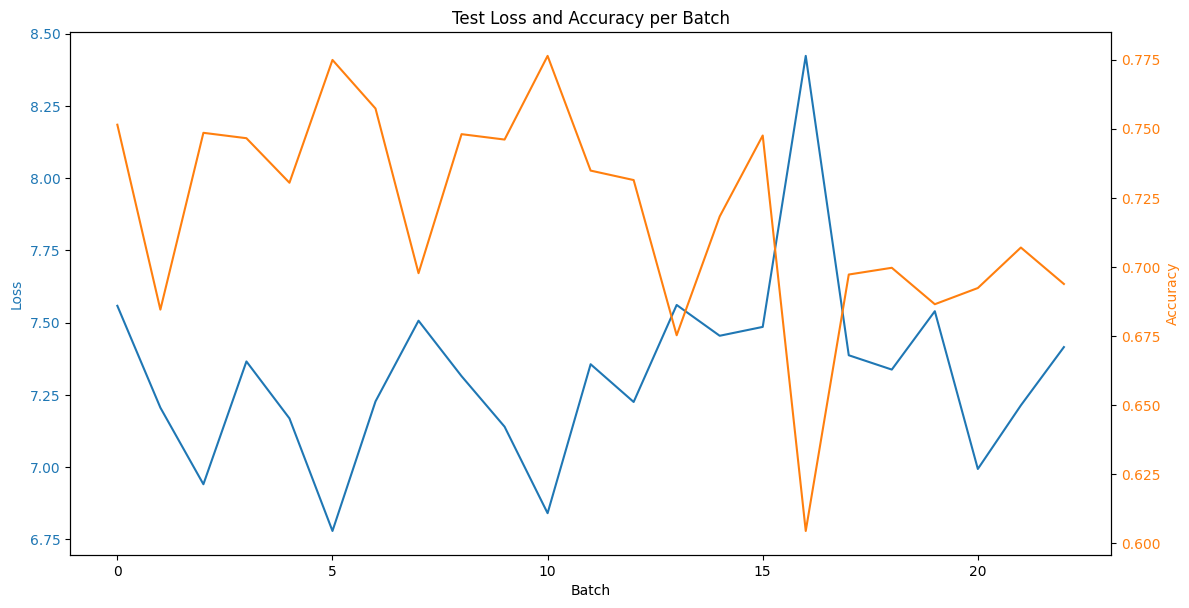

In [ ]:
!pip install rouge-score matplotlib

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from rouge_score import rouge_scorer

# Define the Attention Mechanism class
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        # Linear layers to compute attention scores
        self.Wa = nn.Linear(hidden_dim * 2, hidden_dim)
        self.wa = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        # Compute attention scores
        scores = self.wa(torch.tanh(self.Wa(lstm_output)))
        attention_weights = torch.softmax(scores, dim=1)
        # Compute context vector
        context_vector = torch.bmm(attention_weights.transpose(1, 2), lstm_output)
        return context_vector.squeeze(1)

# Define the BiLSTM with Attention Model class
class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMWithAttention, self).__init__()
        # Bi-directional LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        # Attention mechanism
        self.attention = Attention(hidden_dim)
        # Fully connected layer to produce output
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        # Get LSTM outputs
        lstm_output, _ = self.lstm(x)
        # Apply fully connected layer
        output = self.fc(lstm_output)
        return output

def test_model(model_path, test_dataloader, criterion, token_id_to_token, device):
    # Load the saved model
    checkpoint = torch.load(model_path)
    model = BiLSTMWithAttention(
        input_dim=checkpoint['embedding_dim'],
        hidden_dim=checkpoint['hidden_dim'],
        output_dim=checkpoint['vocab_size']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()  # Set model to evaluation mode

    # Lists to store predictions, references, and metrics
    all_preds = []
    all_refs = []
    test_loss = 0
    correct_preds = 0
    total_preds = 0

    batch_losses = []
    batch_accuracies = []

    # Evaluate the model
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)

            # Reshape outputs and targets for CrossEntropyLoss
            batch_size, seq_len = X_batch.size(0), X_batch.size(1)
            outputs = outputs.view(-1, checkpoint['vocab_size'])  # [batch_size * seq_len, output_dim]
            y_batch = y_batch.view(-1)  # [batch_size * seq_len]

            # Compute loss
            loss = criterion(outputs, y_batch)
            batch_losses.append(loss.item())
            test_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, dim=1)
            correct_preds += (predicted == y_batch).sum().item()
            total_preds += y_batch.size(0)

            # Compute batch accuracy
            batch_accuracy = (predicted == y_batch).sum().item() / y_batch.size(0)
            batch_accuracies.append(batch_accuracy)

            # Decode predictions and references
            preds = predicted.cpu().numpy()
            refs = y_batch.cpu().numpy()
            all_preds.extend(preds)
            all_refs.extend(refs)

    # Compute average test loss and accuracy
    avg_test_loss = test_loss / len(test_dataloader)
    avg_test_accuracy = correct_preds / total_preds

    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {avg_test_accuracy * 100:.2f}%")

    # Decode predictions and references
    decoded_preds = [token_id_to_token.get(str(pred), '[UNK]') for pred in all_preds]
    decoded_refs = [token_id_to_token.get(str(ref), '[UNK]') for ref in all_refs]

    return decoded_preds, decoded_refs, batch_losses, batch_accuracies

# Example usage
model_save_path = '/content/drive/My Drive/MDS/trained_model.pth'
token_id_to_token= '/content/drive/My Drive/MDS/token_id_to_token.json'

with open(json_file_path, 'r') as file:
    token_id_to_token = json.load(file)
# # Define the criterion
# criterion = nn.CrossEntropyLoss()
# Assuming PAD token ID is 0
PAD_ID = 0
criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID)


# Run the test
decoded_preds, decoded_refs, batch_losses, batch_accuracies = test_model(
    model_save_path,
    test_dataloader,
    criterion,
    token_id_to_token,
    device
)

# # # Strip pad token
# decoded_preds = [token for token in decoded_preds if token != '[PAD]']
# decoded_ref= [token for token in decoded_refs if token != '[PAD]']

# Print some examples
print("Decoded Predictions (sample):", decoded_preds[:20])
print("Decoded References (sample):", decoded_refs[:20])

# Define the ROUGE score calculation function
def calculate_rouge_scores(predictions, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    rouge_scores = {
        'rouge1': 0,
        'rouge2': 0,
        'rougeL': 0,
    }

    num_samples = len(predictions)

    for pred, ref in zip(predictions, references):
        scores = scorer.score(' '.join(ref), ' '.join(pred))
        for key in rouge_scores.keys():
            rouge_scores[key] += scores[key].fmeasure

    # Average scores
    for key in rouge_scores.keys():
        rouge_scores[key] /= num_samples

    return rouge_scores

# Plot ROUGE scores
def plot_rouge_scores(rouge_scores):
    plt.figure(figsize=(10, 5))
    plt.bar(rouge_scores.keys(), rouge_scores.values(), color='skyblue')
    plt.xlabel('ROUGE Score')
    plt.ylabel('F-Measure')
    plt.title('ROUGE Scores')
    plt.ylim(0, 1)
    plt.show()

# Calculate ROUGE scores
rouge_scores = calculate_rouge_scores(decoded_preds, decoded_refs)

# Print ROUGE scores
print("ROUGE Scores:")
for key, value in rouge_scores.items():
    print(f"{key}: {value:.4f}")

# Plot ROUGE scores
plot_rouge_scores(rouge_scores)

# Plot Test Loss and Accuracy
def plot_test_metrics(batch_losses, batch_accuracies):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_xlabel('Batch')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.plot(batch_losses, color='tab:blue', label='Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:orange')
    ax2.plot(batch_accuracies, color='tab:orange', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    fig.tight_layout()
    plt.title('Test Loss and Accuracy per Batch')
    plt.show()

# Plot Test Loss and Accuracy
plot_test_metrics(batch_losses, batch_accuracies)


<ipython-input-51-2d9863131f0c>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Test Loss: 7.3232
Test Accuracy: 71.96%
Decoded Predictions (sample): ['title', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Decoded References (sample): ['[CLS]', 'the', 'tool', '##kit', 'also', 'implements', 'suffix', 'array', 'grammar', 'extraction', 'and', 'minimum', 'error', 'rate', 'training', 'it', 'is', 'written', 'in', 'java']
ROUGE Scores:
rouge1: 0.7629
rouge2: 0.7220
rougeL: 0.7618


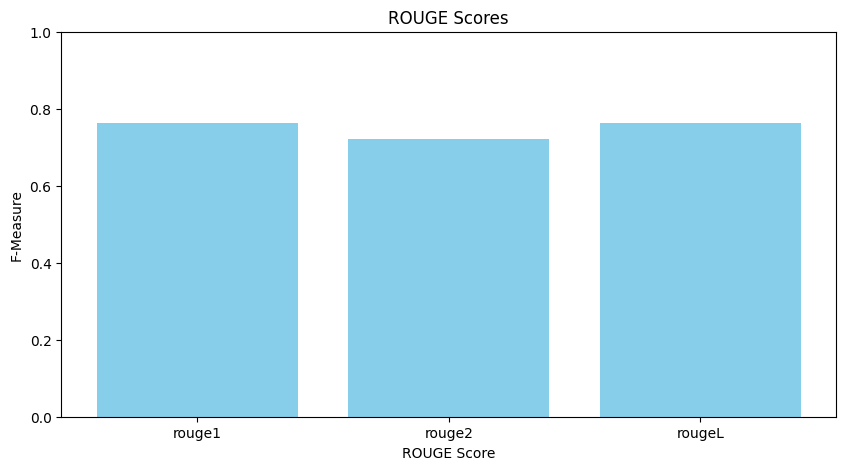

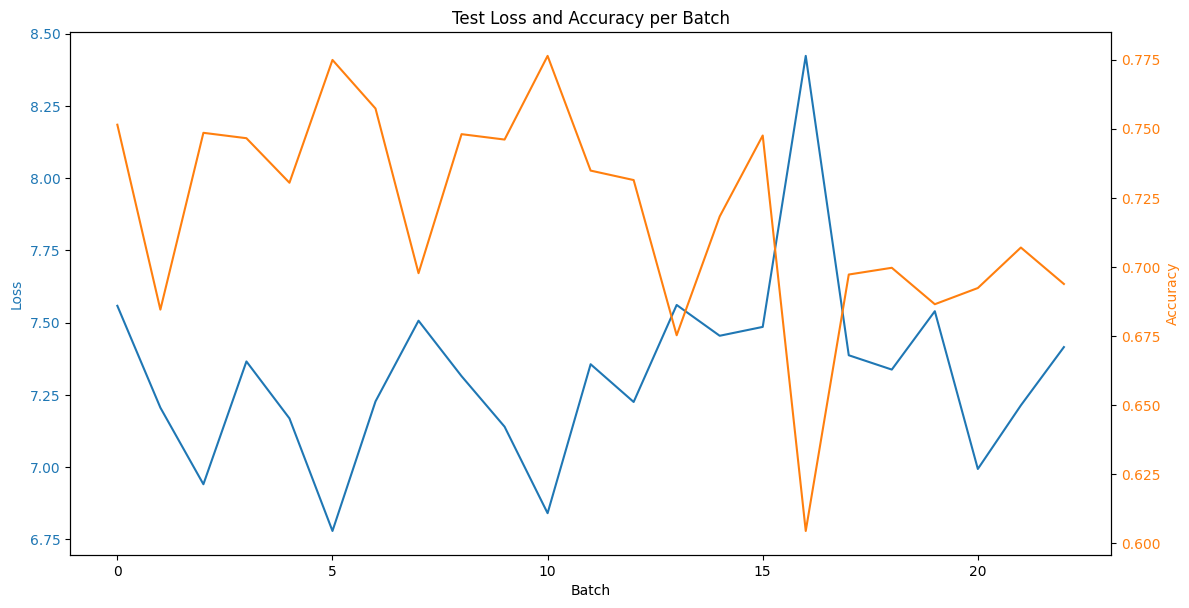

In [ ]:
!pip install rouge-score matplotlib

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from rouge_score import rouge_scorer

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_dim * 2, hidden_dim)
        self.wa = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output, mask=None):
        # Compute attention scores
        scores = self.wa(torch.tanh(self.Wa(lstm_output)))

        if mask is not None:
            # Apply mask: padding tokens should have a very low score
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attention_weights = torch.softmax(scores, dim=1)
        context_vector = torch.bmm(attention_weights.transpose(1, 2), lstm_output)
        return context_vector.squeeze(1)


# Define the BiLSTM with Attention Model class
class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMWithAttention, self).__init__()
        # Bi-directional LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        # Attention mechanism
        self.attention = Attention(hidden_dim)
        # Fully connected layer to produce output
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        # Get LSTM outputs
        lstm_output, _ = self.lstm(x)
        # Apply fully connected layer
        output = self.fc(lstm_output)
        return output



def create_padding_mask(seq, pad_id):
    # Create a mask where padding tokens are marked with 0
    return (seq != pad_id).unsqueeze(1)  # Shape: [batch_size, 1, seq_len]

def test_model(model_path, test_dataloader, criterion, token_id_to_token, device):
    # Load the saved model
    checkpoint = torch.load(model_path)
    model = BiLSTMWithAttention(
        input_dim=checkpoint['embedding_dim'],
        hidden_dim=checkpoint['hidden_dim'],
        output_dim=checkpoint['vocab_size']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()  # Set model to evaluation mode

    # Lists to store predictions, references, and metrics
    all_preds = []
    all_refs = []
    test_loss = 0
    correct_preds = 0
    total_preds = 0

    batch_losses = []
    batch_accuracies = []

    # Evaluate the model
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Create padding mask
            mask = create_padding_mask(X_batch, pad_id=0).to(device)

            # Forward pass
            outputs = model(X_batch)

            # Reshape outputs and targets for CrossEntropyLoss
            batch_size, seq_len = X_batch.size(0), X_batch.size(1)
            outputs = outputs.view(-1, checkpoint['vocab_size'])  # [batch_size * seq_len, output_dim]
            y_batch = y_batch.view(-1)  # [batch_size * seq_len]

            # Compute loss
            loss = criterion(outputs, y_batch)
            batch_losses.append(loss.item())
            test_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, dim=1)
            correct_preds += (predicted == y_batch).sum().item()
            total_preds += y_batch.size(0)

            # Compute batch accuracy
            batch_accuracy = (predicted == y_batch).sum().item() / y_batch.size(0)
            batch_accuracies.append(batch_accuracy)

            # Decode predictions and references
            preds = predicted.cpu().numpy()
            refs = y_batch.cpu().numpy()
            all_preds.extend(preds)
            all_refs.extend(refs)

    # Compute average test loss and accuracy
    avg_test_loss = test_loss / len(test_dataloader)
    avg_test_accuracy = correct_preds / total_preds

    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {avg_test_accuracy * 100:.2f}%")

    # Decode predictions and references
    decoded_preds = [token_id_to_token.get(str(pred), '[UNK]') for pred in all_preds]
    decoded_refs = [token_id_to_token.get(str(ref), '[UNK]') for ref in all_refs]

    return decoded_preds, decoded_refs, batch_losses, batch_accuracies

# Example usage
model_save_path = '/content/drive/My Drive/MDS/trained_model.pth'
token_id_to_token= '/content/drive/My Drive/MDS/token_id_to_token.json'

with open(json_file_path, 'r') as file:
    token_id_to_token = json.load(file)
# # Define the criterion
# criterion = nn.CrossEntropyLoss()
# Assuming PAD token ID is 0
PAD_ID = 0
criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID)


# Run the test
decoded_preds, decoded_refs, batch_losses, batch_accuracies = test_model(
    model_save_path,
    test_dataloader,
    criterion,
    token_id_to_token,
    device
)

# # # Strip pad token
# decoded_preds = [token for token in decoded_preds if token != '[PAD]']
# decoded_ref= [token for token in decoded_refs if token != '[PAD]']

# Print some examples
print("Decoded Predictions (sample):", decoded_preds[:20])
print("Decoded References (sample):", decoded_refs[:20])

# Define the ROUGE score calculation function
def calculate_rouge_scores(predictions, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    rouge_scores = {
        'rouge1': 0,
        'rouge2': 0,
        'rougeL': 0,
    }

    num_samples = len(predictions)

    for pred, ref in zip(predictions, references):
        scores = scorer.score(' '.join(ref), ' '.join(pred))
        for key in rouge_scores.keys():
            rouge_scores[key] += scores[key].fmeasure

    # Average scores
    for key in rouge_scores.keys():
        rouge_scores[key] /= num_samples

    return rouge_scores

# Plot ROUGE scores
def plot_rouge_scores(rouge_scores):
    plt.figure(figsize=(10, 5))
    plt.bar(rouge_scores.keys(), rouge_scores.values(), color='skyblue')
    plt.xlabel('ROUGE Score')
    plt.ylabel('F-Measure')
    plt.title('ROUGE Scores')
    plt.ylim(0, 1)
    plt.show()

# Calculate ROUGE scores
rouge_scores = calculate_rouge_scores(decoded_preds, decoded_refs)

# Print ROUGE scores
print("ROUGE Scores:")
for key, value in rouge_scores.items():
    print(f"{key}: {value:.4f}")

# Plot ROUGE scores
plot_rouge_scores(rouge_scores)

# Plot Test Loss and Accuracy
def plot_test_metrics(batch_losses, batch_accuracies):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_xlabel('Batch')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.plot(batch_losses, color='tab:blue', label='Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:orange')
    ax2.plot(batch_accuracies, color='tab:orange', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    fig.tight_layout()
    plt.title('Test Loss and Accuracy per Batch')
    plt.show()

# Plot Test Loss and Accuracy
plot_test_metrics(batch_losses, batch_accuracies)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

# Load BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()  # Set BERT to evaluation mode

# Load encoded data
article_encoded = torch.load('/content/drive/My Drive/MDS/article_encoded.pt', weights_only=False)
summary_encoded = torch.load('/content/drive/My Drive/MDS/summary_encoded.pt', weights_only=False)
article_embeddings = torch.load('/content/drive/My Drive/MDS/article_embeddings.pt', weights_only=False)
summary_ids = torch.load('/content/drive/My Drive/MDS/summary_ids.pt', weights_only=False)
summary_padded = torch.load('/content/drive/My Drive/MDS/summary_padded.pt', weights_only=False)

# Define Attention Mechanism with Masking
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_dim * 2, hidden_dim)
        self.wa = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output, mask):
        scores = self.wa(torch.tanh(self.Wa(lstm_output)))
        scores = scores.masked_fill(mask.unsqueeze(-1) == 0, float('-inf'))  # Apply mask
        attention_weights = torch.softmax(scores, dim=1)
        context_vector = torch.bmm(attention_weights.transpose(1, 2), lstm_output)
        return context_vector.squeeze(1)

# Define BiLSTM with Attention Model
class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Output for each token position

    def forward(self, x, mask):
        lstm_output, _ = self.lstm(x)  # Shape: [batch_size, seq_len, hidden_dim * 2]
        context_vector = self.attention(lstm_output, mask)  # Shape: [batch_size, hidden_dim * 2]
        output = self.fc(lstm_output)  # Output shape: [batch_size, seq_len, output_dim]
        return output

# Define model parameters
input_dim = bert_model.config.hidden_size  # Size of BERT embeddings (usually 768 for bert-base)
hidden_dim = 128
output_dim = len(bert_tokenizer)  # Size of the vocabulary for the output layer
print(f"Output dim: {output_dim}")

# Initialize model, loss, optimizer, and scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiLSTMWithAttention(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Example scheduler

# Create dataset
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split data into train, validation, and test sets
def split_data(X, y, train_size=0.7, val_size=0.15, test_size=0.15):
    num_samples = len(X)
    indices = torch.randperm(num_samples).tolist()
    train_end = int(num_samples * train_size)
    val_end = train_end + int(num_samples * val_size)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    X_train = torch.stack([X[i] for i in train_indices])
    y_train = torch.stack([y[i] for i in train_indices])
    X_val = torch.stack([X[i] for i in val_indices])
    y_val = torch.stack([y[i] for i in val_indices])
    X_test = torch.stack([X[i] for i in test_indices])
    y_test = torch.stack([y[i] for i in test_indices])

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(article_embeddings, summary_padded)

# Create DataLoaders
batch_size = 4
num_epochs = 10
train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Debugging: Check DataLoader output
for X_batch, y_batch in train_dataloader:
    print("Batch X shape:", X_batch.shape)
    print("Batch y shape:", y_batch.shape)
    break  # Remove this break to see more batches

# Compute loss with masking
def compute_loss(outputs, targets, pad_token_id, criterion):
    mask = (targets != pad_token_id)  # Create mask: 1 for valid tokens, 0 for padding tokens
    outputs = outputs.view(-1, output_dim)  # Reshape outputs to [batch_size * seq_len, output_dim]
    targets = targets.view(-1)  # Reshape targets to [batch_size * seq_len]

    # Mask out the padding tokens in the loss computation
    masked_outputs = outputs[mask.view(-1)]
    masked_targets = targets[mask.view(-1)]

    if len(masked_targets) == 0:
        return torch.tensor(0.0, device=outputs.device)

    loss = criterion(masked_outputs, masked_targets)
    return loss

def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs, pad_token_id, save_path='trained_model.pth'):
    # Lists to store losses and accuracies
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Initialize total loss for training
        total_loss = 0
        model.train()

        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            # Create mask
            mask = (y_batch != pad_token_id).long()  # Mask of shape [batch_size, seq_len]

            # Forward pass
            outputs = model(X_batch, mask)

            # Compute loss
            loss = compute_loss(outputs, y_batch, pad_token_id, criterion)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Update the learning rate
        scheduler.step()

        # Compute average training loss
        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}")

        # Validation
        model.eval()
        val_loss = 0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for X_batch, y_batch in val_dataloader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # Create mask
                mask = (y_batch != pad_token_id).long()  # Mask of shape [batch_size, seq_len]

                # Forward pass
                outputs = model(X_batch, mask)

                # Compute loss
                loss = compute_loss(outputs, y_batch, pad_token_id, criterion)
                val_loss += loss.item()

                # Compute accuracy
                _, predicted = torch.max(outputs, dim=2)
                correct_preds += (predicted[mask == 1] == y_batch[mask == 1]).sum().item()
                total_preds += mask.sum().item()

        # Compute average validation loss and accuracy
        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_accuracy = correct_preds / total_preds
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy * 100:.2f}%")
        print(f"Learning Rate: {scheduler.get_last_lr()}")

        # Save the model after each epoch
        try:
            torch.save({
                'model_state_dict': model.state_dict(),
                'vocab_size': output_dim,
                'embedding_dim': input_dim,
                'hidden_dim': hidden_dim,
                'num_epochs': num_epochs,
                'batch_size': batch_size
            }, save_path)
            print(f"Model saved to {save_path}")
        except Exception as e:
            print(f"Error saving the model: {e}")

        # Debug: Check for NaN values in losses
        if torch.isnan(torch.tensor(avg_train_loss)) or torch.isnan(torch.tensor(avg_val_loss)):
            raise ValueError("NaN values encountered in loss.")

    return train_losses, val_losses, val_accuracies

import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, [a * 100 for a in val_accuracies], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# After training
pad_token_id = bert_tokenizer.pad_token_id
train_losses, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs, pad_token_id)
plot_metrics(train_losses, val_losses, val_accuracies)

# Define the model save path
model_save_path = '/content/drive/My Drive/MDS/new_model.pth'


Mounted at /content/drive
Output dim: 30522
Batch X shape: torch.Size([4, 512, 768])
Batch y shape: torch.Size([4, 512])
Epoch 1/10
Epoch 1/10, Training Loss: 7.469838512278049
Epoch 1/10, Validation Loss: 6.988597227179485, Validation Accuracy: 5.31%
Learning Rate: [0.001]
Model saved to trained_model.pth
Epoch 2/10
Epoch 2/10, Training Loss: 6.818715238125525
Epoch 2/10, Validation Loss: 6.961341401805049, Validation Accuracy: 5.39%
Learning Rate: [0.001]
Model saved to trained_model.pth
Epoch 3/10


KeyboardInterrupt: 

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Output dim: 30522
Batch X shape: torch.Size([4, 512, 768])
Batch y shape: torch.Size([4, 512])

Epoch 1/1
Training Loss: 7.3325
Validation Loss: 7.0444, Validation Accuracy: 5.14%
Learning Rate: 0.001000
Model saved to /content/drive/My Drive/MDS/new_model.pth


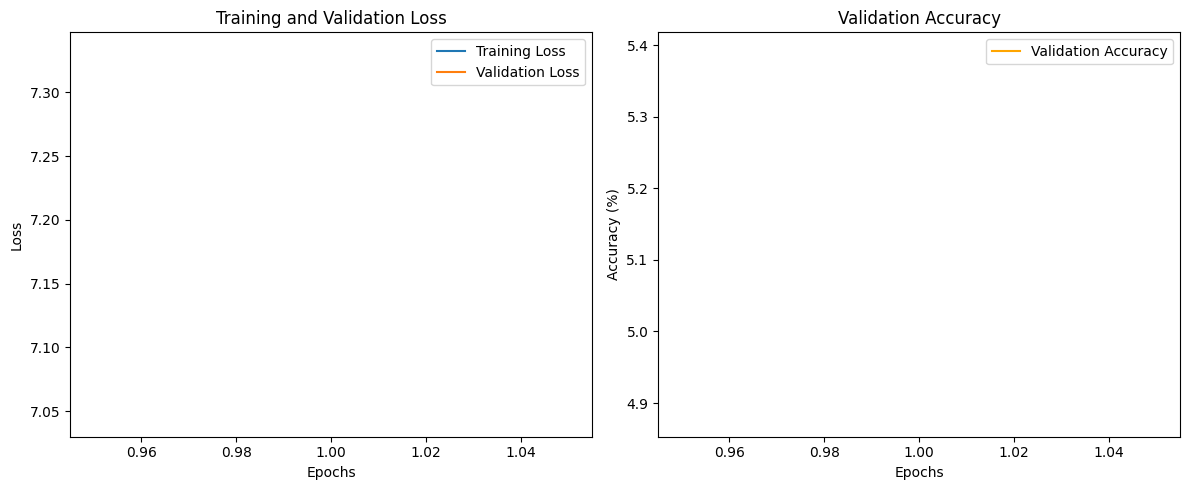

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt

# Load BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()  # Set BERT to evaluation mode

# Load encoded data
article_encoded = torch.load('/content/drive/My Drive/MDS/article_encoded.pt', weights_only=False)
summary_encoded = torch.load('/content/drive/My Drive/MDS/summary_encoded.pt', weights_only=False)
article_embeddings = torch.load('/content/drive/My Drive/MDS/article_embeddings.pt', weights_only=False)
summary_ids = torch.load('/content/drive/My Drive/MDS/summary_ids.pt', weights_only=False)
summary_padded = torch.load('/content/drive/My Drive/MDS/summary_padded.pt', weights_only=False)

# Define Attention Mechanism
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_dim * 2, hidden_dim)
        self.wa = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        scores = self.wa(torch.tanh(self.Wa(lstm_output)))
        attention_weights = torch.softmax(scores, dim=1)
        context_vector = torch.bmm(attention_weights.transpose(1, 2), lstm_output)
        return context_vector.squeeze(1)

# Define BiLSTM with Attention Model
class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Output for each token position

    def forward(self, x):
        lstm_output, _ = self.lstm(x)  # Shape: [batch_size, seq_len, hidden_dim * 2]
        output = self.fc(lstm_output)  # Output shape: [batch_size, seq_len, output_dim]
        return output

# Define model parameters
input_dim = bert_model.config.hidden_size  # Size of BERT embeddings (usually 768 for bert-base)
hidden_dim = 256
output_dim = len(bert_tokenizer)  # Size of the vocabulary for the output layer
print(f"Output dim: {output_dim}")

# Initialize model, loss, optimizer, and scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiLSTMWithAttention(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding index in loss computation
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Example scheduler

# Create dataset
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split data into train, validation, and test sets
def split_data(X, y, train_size=0.7, val_size=0.15, test_size=0.15):
    num_samples = len(X)
    indices = torch.randperm(num_samples).tolist()
    train_end = int(num_samples * train_size)
    val_end = train_end + int(num_samples * val_size)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    X_train = torch.stack([X[i] for i in train_indices])
    y_train = torch.stack([y[i] for i in train_indices])
    X_val = torch.stack([X[i] for i in val_indices])
    y_val = torch.stack([y[i] for i in val_indices])
    X_test = torch.stack([X[i] for i in test_indices])
    y_test = torch.stack([y[i] for i in test_indices])

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(article_embeddings, summary_padded)

# Create DataLoaders
batch_size = 4
num_epochs = 1
train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Debugging: Check DataLoader output
for X_batch, y_batch in train_dataloader:
    print("Batch X shape:", X_batch.shape)
    print("Batch y shape:", y_batch.shape)
    break  # Remove this break to see more batches

import numpy as np

def compute_loss(outputs, targets, pad_token_id, criterion):
    # Create mask to ignore padding tokens
    mask = (targets != pad_token_id)

    # Flatten outputs and targets
    batch_size, seq_len, output_dim = outputs.size()
    outputs = outputs.view(-1, output_dim)  # [batch_size * seq_len, output_dim]
    targets = targets.view(-1)  # [batch_size * seq_len]

    # Mask for valid positions
    masked_indices = mask.view(-1)
    masked_outputs = outputs[masked_indices]
    masked_targets = targets[masked_indices]

    # Compute loss
    if masked_outputs.size(0) == 0:  # No non-padding tokens
        return torch.tensor(0.0, device=outputs.device)

    loss = criterion(masked_outputs, masked_targets)
    return loss

def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs, pad_token_id, save_path='trained_model.pth', patience=5):
    # Lists to store losses and accuracies
    train_losses = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Initialize total loss for training
        total_loss = 0
        model.train()

        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            # Create mask
            mask = (y_batch != pad_token_id).long()  # Mask of shape [batch_size, seq_len]

            # Forward pass
            outputs = model(X_batch)

            # Compute loss
            loss = compute_loss(outputs, y_batch, pad_token_id, criterion)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Update the learning rate
        scheduler.step()

        # Compute average training loss
        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print(f"Training Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for X_batch, y_batch in val_dataloader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # Create mask
                mask = (y_batch != pad_token_id).long()  # Mask of shape [batch_size, seq_len]

                # Forward pass
                outputs = model(X_batch)

                # Compute loss
                loss = compute_loss(outputs, y_batch, pad_token_id, criterion)
                val_loss += loss.item()

                # Compute accuracy
                _, predicted = torch.max(outputs, dim=2)
                correct_preds += (predicted[mask == 1] == y_batch[mask == 1]).sum().item()
                total_preds += mask.sum().item()

        # Compute average validation loss and accuracy
        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_accuracy = correct_preds / total_preds if total_preds > 0 else 0
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy * 100:.2f}%")
        print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

        # Save the model if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            try:
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'vocab_size': output_dim,
                    'embedding_dim': input_dim,
                    'hidden_dim': hidden_dim,
                    'num_epochs': num_epochs,
                    'batch_size': batch_size
                }, save_path)
                print(f"Model saved to {save_path}")
            except Exception as e:
                print(f"Error saving the model: {e}")
        else:
            patience_counter += 1

        # Check if early stopping condition is met
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    return train_losses, val_losses, val_accuracies

def plot_metrics(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, [a * 100 for a in val_accuracies], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# After training
pad_token_id = 0  # Padded token ID
patience = 5
model_save_path = '/content/drive/My Drive/MDS/new_model.pth'
train_losses, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs, pad_token_id, save_path=model_save_path, patience=patience)
plot_metrics(train_losses, val_losses, val_accuracies)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install rouge_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer

# Load BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()  # Set BERT to evaluation mode

# Load encoded data
article_encoded = torch.load('/content/drive/My Drive/MDS/article_encoded.pt', weights_only=False)
summary_encoded = torch.load('/content/drive/My Drive/MDS/summary_encoded.pt', weights_only=False)
article_embeddings = torch.load('/content/drive/My Drive/MDS/article_embeddings.pt', weights_only=False)
summary_ids = torch.load('/content/drive/My Drive/MDS/summary_ids.pt', weights_only=False)
summary_padded = torch.load('/content/drive/My Drive/MDS/summary_padded.pt', weights_only=False)

# Define Attention Mechanism
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_dim * 2, hidden_dim)
        self.wa = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        scores = self.wa(torch.tanh(self.Wa(lstm_output)))
        attention_weights = torch.softmax(scores, dim=1)
        context_vector = torch.bmm(attention_weights.transpose(1, 2), lstm_output)
        return context_vector.squeeze(1)

# Define BiLSTM with Attention Model
class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Output for each token position

    def forward(self, x):
        lstm_output, _ = self.lstm(x)  # Shape: [batch_size, seq_len, hidden_dim * 2]
        output = self.fc(lstm_output)  # Output shape: [batch_size, seq_len, output_dim]
        return output

# Define model parameters
input_dim = bert_model.config.hidden_size  # Size of BERT embeddings (usually 768 for bert-base)
hidden_dim = 256
output_dim = len(bert_tokenizer)  # Size of the vocabulary for the output layer
print(f"Output dim: {output_dim}")

# Initialize model, loss, optimizer, and scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiLSTMWithAttention(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding index in loss computation
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Example scheduler

# Create dataset
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split data into train, validation, and test sets
def split_data(X, y, train_size=0.7, val_size=0.15, test_size=0.15):
    num_samples = len(X)
    indices = torch.randperm(num_samples).tolist()
    train_end = int(num_samples * train_size)
    val_end = train_end + int(num_samples * val_size)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    X_train = torch.stack([X[i] for i in train_indices])
    y_train = torch.stack([y[i] for i in train_indices])
    X_val = torch.stack([X[i] for i in val_indices])
    y_val = torch.stack([y[i] for i in val_indices])
    X_test = torch.stack([X[i] for i in test_indices])
    y_test = torch.stack([y[i] for i in test_indices])

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(article_embeddings, summary_padded)

# Create DataLoaders
batch_size = 4
num_epochs = 50
train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Debugging: Check DataLoader output
for X_batch, y_batch in train_dataloader:
    print("Batch X shape:", X_batch.shape)
    print("Batch y shape:", y_batch.shape)
    break  # Remove this break to see more batches

import numpy as np

def compute_loss(outputs, targets, pad_token_id, criterion):
    # Create mask to ignore padding tokens
    mask = (targets != pad_token_id)

    # Flatten outputs and targets
    batch_size, seq_len, output_dim = outputs.size()
    outputs = outputs.view(-1, output_dim)  # [batch_size * seq_len, output_dim]
    targets = targets.view(-1)  # [batch_size * seq_len]

    # Mask for valid positions
    masked_indices = mask.view(-1)
    masked_outputs = outputs[masked_indices]
    masked_targets = targets[masked_indices]

    # Compute loss
    if masked_outputs.size(0) == 0:  # No non-padding tokens
        return torch.tensor(0.0, device=outputs.device)

    loss = criterion(masked_outputs, masked_targets)
    return loss

def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs, pad_token_id, save_path='trained_model.pth', patience=50):
    # Lists to store losses and accuracies
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_rouge_scores = []

    best_val_loss = float('inf')
    patience_counter = 0

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Initialize total loss for training
        total_loss = 0
        model.train()

        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            # Create mask
            mask = (y_batch != pad_token_id).long()  # Mask of shape [batch_size, seq_len]

            # Forward pass
            outputs = model(X_batch)

            # Compute loss
            loss = compute_loss(outputs, y_batch, pad_token_id, criterion)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Update the learning rate
        scheduler.step()

        # Compute average training loss
        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print(f"Training Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0
        correct_preds = 0
        total_preds = 0
        rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

        with torch.no_grad():
            for X_batch, y_batch in val_dataloader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # Create mask
                mask = (y_batch != pad_token_id).long()  # Mask of shape [batch_size, seq_len]

                # Forward pass
                outputs = model(X_batch)

                # Compute loss
                loss = compute_loss(outputs, y_batch, pad_token_id, criterion)
                val_loss += loss.item()

                # Convert model output to text summaries
                _, predicted = torch.max(outputs, dim=2)
                predicted_summaries = [bert_tokenizer.decode(p, skip_special_tokens=True) for p in predicted]
                true_summaries = [bert_tokenizer.decode(t, skip_special_tokens=True) for t in y_batch]

                # Compute ROUGE scores
                for pred_summary, true_summary in zip(predicted_summaries, true_summaries):
                    scores = scorer.score(true_summary, pred_summary)
                    for key in scores:
                        rouge_scores[key].append(scores[key].fmeasure)

                # Compute accuracy
                correct_preds += (predicted[mask == 1] == y_batch[mask == 1]).sum().item()
                total_preds += mask.sum().item()

        # Compute average validation loss and accuracy
        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_accuracy = correct_preds / total_preds if total_preds > 0 else 0
        avg_rouge_scores = {key: np.mean(val) for key, val in rouge_scores.items()}
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)
        val_rouge_scores.append(avg_rouge_scores)

        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy * 100:.2f}%")
        print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
        print(f"ROUGE Scores: {avg_rouge_scores}")

        # Save the model if validation loss improved
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            try:
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'vocab_size': output_dim,
                    'embedding_dim': input_dim,
                    'hidden_dim': hidden_dim,
                    'num_epochs': num_epochs,
                    'batch_size': batch_size
                }, save_path)
                print(f"Model saved to {save_path}")
            except Exception as e:
                print(f"Error saving the model: {e}")
        else:
            patience_counter += 1

        # Check if early stopping condition is met
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    return train_losses, val_losses, val_accuracies, val_rouge_scores

def plot_metrics(train_losses, val_losses, val_accuracies, val_rouge_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 10))

    # Plot training and validation loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, [a * 100 for a in val_accuracies], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()

    # Plot ROUGE scores
    avg_rouge1 = [score['rouge1'] for score in val_rouge_scores]
    avg_rouge2 = [score['rouge2'] for score in val_rouge_scores]
    avg_rougeL = [score['rougeL'] for score in val_rouge_scores]

    plt.subplot(2, 2, 3)
    plt.plot(epochs, avg_rouge1, label='ROUGE-1 F1', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('ROUGE-1 F1')
    plt.title('ROUGE-1 Score')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, avg_rouge2, label='ROUGE-2 F1', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('ROUGE-2 F1')
    plt.title('ROUGE-2 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# After training
pad_token_id = 0  # Padded token ID
patience = 50
model_save_path = '/content/drive/My Drive/MDS/new_model.pth'
train_losses, val_losses, val_accuracies, val_rouge_scores = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs, pad_token_id, save_path=model_save_path, patience=patience)
plot_metrics(train_losses, val_losses, val_accuracies, val_rouge_scores)

Mounted at /content/drive
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=2f819382917ea3f189543d81e6b90b3ff2e9fa265ba9219d0da7bd106a0a5b0e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Output dim: 30522
Batch X shape: torch.Size([4, 512, 768])
Batch y shape: torch.Size([4, 512])

Epoch 1/50
Training Loss: 7.3440
Validation Loss: 7.0499, Validation Accuracy: 5.08%
Learning Rate: 0.001000
ROUGE Scores: {'rouge1': 0.027034600554442578, 'rouge2': 0.0024725648233099285, 'rougeL': 0.026936549578365974}
Model saved to /content/drive/My Drive/MDS/new_model.pth

Epoch 2/50
Training Loss: 6.7764
Validation Loss: 7.0442, Validation Accuracy: 5.30%
Learning Rate: 0.001000
ROUGE Scores: {'rouge1': 0.023962748745607616, 'rouge2': 0.0010552018655268403, 'rougeL': 0.02345291747460455}
Model saved to /content/drive/My Drive/MDS/new_model.pth

Epoch 3/50
Training Loss: 6.6596
Validation Loss: 7.0273, Validation Accuracy: 5.47%
Learning Rate: 0.001000
ROUGE Scores: {'rouge1': 0.04127080773907962, 'rouge2': 0.00319015169108762, 'rougeL': 0.03474197026764088}
Model saved to /content/drive/My Drive/MDS/new_model.pth

Epoch 4/50
Training Loss: 6.5225
Validation Loss: 7.0325, Validation Acc

Mounted at /content/drive
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=f360e3b96ea3a737dda19291e5fd183daa984d398465511f5a9be9cebb3ce43e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Output dim: 30522
Batch X shape: torch.Size([4, 512, 768])
Batch y shape: torch.Size([4, 512])

Epoch 1/25
Training Loss: 7.3651
Validation Loss: 6.9161, Validation Accuracy: 5.25%
Learning Rate: 0.001000
ROUGE Scores: {'rouge1': 0.022426639607117917, 'rouge2': 0.0008607185848915685, 'rougeL': 0.022426639607117917}
Model saved to /content/drive/My Drive/MDS/new_model.pth

Epoch 2/25
Training Loss: 6.7761
Validation Loss: 6.8868, Validation Accuracy: 5.60%
Learning Rate: 0.001000
ROUGE Scores: {'rouge1': 0.038903827388542464, 'rouge2': 0.0025943364840182647, 'rougeL': 0.0341232797709146}
Model saved to /content/drive/My Drive/MDS/new_model.pth

Epoch 3/25
Training Loss: 6.6617
Validation Loss: 6.8862, Validation Accuracy: 5.47%
Learning Rate: 0.001000
ROUGE Scores: {'rouge1': 0.06714935669860612, 'rouge2': 0.004466369150317558, 'rougeL': 0.05540626419070052}
Model saved to /content/drive/My Drive/MDS/new_model.pth

Epoch 4/25
Training Loss: 6.5084
Validation Loss: 6.9042, Validation Acc

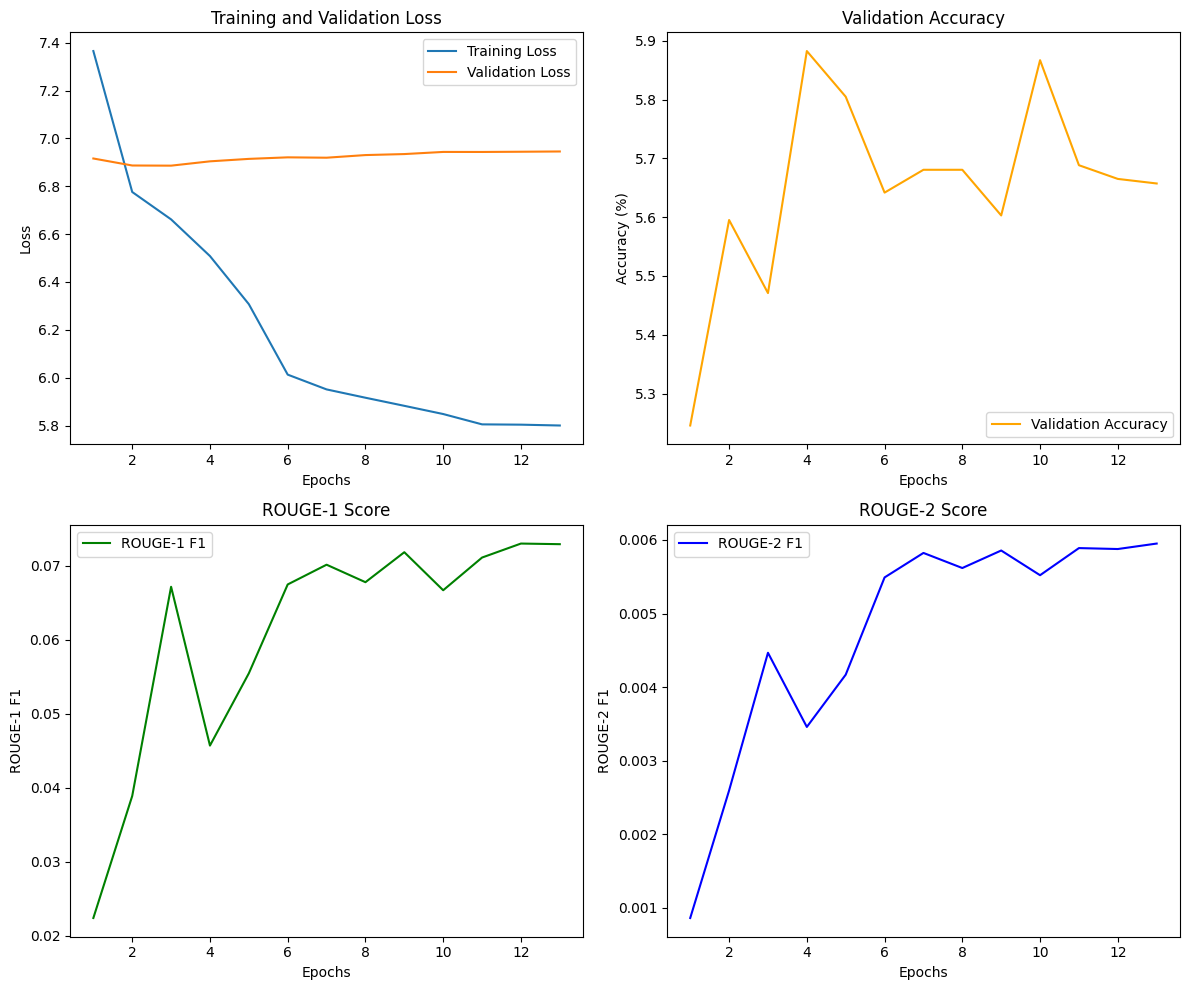

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install rouge_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer

# Load BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()  # Set BERT to evaluation mode

# Load encoded data
article_encoded = torch.load('/content/drive/My Drive/MDS/article_encoded.pt', weights_only=False)
summary_encoded = torch.load('/content/drive/My Drive/MDS/summary_encoded.pt', weights_only=False)
article_embeddings = torch.load('/content/drive/My Drive/MDS/article_embeddings.pt', weights_only=False)
summary_ids = torch.load('/content/drive/My Drive/MDS/summary_ids.pt', weights_only=False)
summary_padded = torch.load('/content/drive/My Drive/MDS/summary_padded.pt', weights_only=False)

# Define Attention Mechanism
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_dim * 2, hidden_dim)
        self.wa = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        scores = self.wa(torch.tanh(self.Wa(lstm_output)))
        attention_weights = torch.softmax(scores, dim=1)
        context_vector = torch.bmm(attention_weights.transpose(1, 2), lstm_output)
        return context_vector.squeeze(1)

# Define BiLSTM with Attention Model
class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Output for each token position

    def forward(self, x):
        lstm_output, _ = self.lstm(x)  # Shape: [batch_size, seq_len, hidden_dim * 2]
        output = self.fc(lstm_output)  # Output shape: [batch_size, seq_len, output_dim]
        return output

# Define model parameters
input_dim = bert_model.config.hidden_size  # Size of BERT embeddings (usually 768 for bert-base)
hidden_dim = 256
output_dim = len(bert_tokenizer)  # Size of the vocabulary for the output layer
print(f"Output dim: {output_dim}")

# Initialize model, loss, optimizer, and scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiLSTMWithAttention(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding index in loss computation
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Example scheduler

# Create dataset
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split data into train, validation, and test sets
def split_data(X, y, train_size=0.7, val_size=0.15, test_size=0.15):
    num_samples = len(X)
    indices = torch.randperm(num_samples).tolist()
    train_end = int(num_samples * train_size)
    val_end = train_end + int(num_samples * val_size)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    X_train = torch.stack([X[i] for i in train_indices])
    y_train = torch.stack([y[i] for i in train_indices])
    X_val = torch.stack([X[i] for i in val_indices])
    y_val = torch.stack([y[i] for i in val_indices])
    X_test = torch.stack([X[i] for i in test_indices])
    y_test = torch.stack([y[i] for i in test_indices])

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(article_embeddings, summary_padded)

# Create DataLoaders
batch_size = 4
num_epochs = 25
train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Debugging: Check DataLoader output
for X_batch, y_batch in train_dataloader:
    print("Batch X shape:", X_batch.shape)
    print("Batch y shape:", y_batch.shape)
    break  # Remove this break to see more batches

import numpy as np

def compute_loss(outputs, targets, pad_token_id, criterion):
    # Create mask to ignore padding tokens
    mask = (targets != pad_token_id)

    # Flatten outputs and targets
    batch_size, seq_len, output_dim = outputs.size()
    outputs = outputs.view(-1, output_dim)  # [batch_size * seq_len, output_dim]
    targets = targets.view(-1)  # [batch_size * seq_len]

    # Mask for valid positions
    masked_indices = mask.view(-1)
    masked_outputs = outputs[masked_indices]
    masked_targets = targets[masked_indices]

    # Compute loss
    if masked_outputs.size(0) == 0:  # No non-padding tokens
        return torch.tensor(0.0, device=outputs.device)

    loss = criterion(masked_outputs, masked_targets)
    return loss

def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs, pad_token_id, save_path='trained_model.pth', patience=10):
    # Lists to store losses and accuracies
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_rouge_scores = []

    best_val_loss = float('inf')
    patience_counter = 0

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Initialize total loss for training
        total_loss = 0
        model.train()

        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            # Create mask
            mask = (y_batch != pad_token_id).long()  # Mask of shape [batch_size, seq_len]

            # Forward pass
            outputs = model(X_batch)

            # Compute loss
            loss = compute_loss(outputs, y_batch, pad_token_id, criterion)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Update the learning rate
        scheduler.step()

        # Compute average training loss
        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print(f"Training Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0
        correct_preds = 0
        total_preds = 0
        rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

        with torch.no_grad():
            for X_batch, y_batch in val_dataloader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # Create mask
                mask = (y_batch != pad_token_id).long()  # Mask of shape [batch_size, seq_len]

                # Forward pass
                outputs = model(X_batch)

                # Compute loss
                loss = compute_loss(outputs, y_batch, pad_token_id, criterion)
                val_loss += loss.item()

                # Convert model output to text summaries
                _, predicted = torch.max(outputs, dim=2)
                predicted_summaries = [bert_tokenizer.decode(p, skip_special_tokens=True) for p in predicted]
                true_summaries = [bert_tokenizer.decode(t, skip_special_tokens=True) for t in y_batch]

                # Compute ROUGE scores
                for pred_summary, true_summary in zip(predicted_summaries, true_summaries):
                    scores = scorer.score(true_summary, pred_summary)
                    for key in scores:
                        rouge_scores[key].append(scores[key].fmeasure)

                # Compute accuracy
                correct_preds += (predicted[mask == 1] == y_batch[mask == 1]).sum().item()
                total_preds += mask.sum().item()

        # Compute average validation loss and accuracy
        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_accuracy = correct_preds / total_preds if total_preds > 0 else 0
        avg_rouge_scores = {key: np.mean(val) for key, val in rouge_scores.items()}
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)
        val_rouge_scores.append(avg_rouge_scores)

        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy * 100:.2f}%")
        print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
        print(f"ROUGE Scores: {avg_rouge_scores}")

        # Save the model if validation loss improved
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            try:
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'vocab_size': output_dim,
                    'embedding_dim': input_dim,
                    'hidden_dim': hidden_dim,
                    'num_epochs': num_epochs,
                    'batch_size': batch_size
                }, save_path)
                print(f"Model saved to {save_path}")
            except Exception as e:
                print(f"Error saving the model: {e}")
        else:
            patience_counter += 1

        # Check if early stopping condition is met
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    return train_losses, val_losses, val_accuracies, val_rouge_scores

def plot_metrics(train_losses, val_losses, val_accuracies, val_rouge_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 10))

    # Plot training and validation loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, [a * 100 for a in val_accuracies], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()

    # Plot ROUGE scores
    avg_rouge1 = [score['rouge1'] for score in val_rouge_scores]
    avg_rouge2 = [score['rouge2'] for score in val_rouge_scores]
    avg_rougeL = [score['rougeL'] for score in val_rouge_scores]

    plt.subplot(2, 2, 3)
    plt.plot(epochs, avg_rouge1, label='ROUGE-1 F1', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('ROUGE-1 F1')
    plt.title('ROUGE-1 Score')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, avg_rouge2, label='ROUGE-2 F1', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('ROUGE-2 F1')
    plt.title('ROUGE-2 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# After training
pad_token_id = 0  # Padded token ID
patience = 10
model_save_path = '/content/drive/My Drive/MDS/new_model.pth'
train_losses, val_losses, val_accuracies, val_rouge_scores = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs, pad_token_id, save_path=model_save_path, patience=patience)
plot_metrics(train_losses, val_losses, val_accuracies, val_rouge_scores)